In [1]:
pip install opencv-contrib-python

  Using cached https://files.pythonhosted.org/packages/18/32/c302e32d1cf59fd4132c3d82e4182ddd61ac4f0e22cebec44eb36d2e0fd3/opencv_contrib_python-4.2.0.32-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/62/20/4d43e141b5bc426ba38274933ef8e76e85c7adea2c321ecf9ebf7421cedf/numpy-1.18.1-cp36-cp36m-manylinux1_x86_64.whl
Note: you may need to restart the kernel to use updated packages.


In [1]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import img_to_array
from loader_util.preprocessing import AspectAwarePreprocessor, ImageToArrayPreprocessor
from loader_util.datasets import SimpleDatasetLoader
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from loader_util.nn.conv import LeNet
from imutils import paths
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.axes._axes as axes
import cv2
import os
sns.set()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [3]:
dataFolder = r"cellImages2"

args = {
    'dataset': dataFolder
}

imagePaths = list(paths.list_images(args['dataset']))

In [4]:
# initialise the preprocessors
sp = AspectAwarePreprocessor(64, 64)
iap = ImageToArrayPreprocessor()

# load the dataset
sdl = SimpleDatasetLoader(preprocessors=[sp, iap])
data, labels = sdl.load(imagePaths, verbose=500)
data = data.astype('float') / 255.0

[INFO] processed 500/1337
[INFO] processed 1000/1337


In [115]:
# data_gray = []
# 
# for ind, processed_image in enumerate(data):
#     gray = cv2.cvtColor(processed_image, cv2.COLOR_BGR2GRAY)
#     gray = img_to_array(gray)
#     #print(processed_image.shape)
#     #print(gray.shape)
#     data_gray.append(gray)
# data_gray = np.array(data_gray)
# data = data_gray.astype('float') / 255.0 # scale image to 0-1

In [5]:
le = LabelEncoder().fit(labels)
labels = to_categorical(le.transform(labels), 3)
trainx, testx, trainy, testy = train_test_split(data, labels, test_size=0.3,
                                                random_state=42, stratify=labels)

# imbalance
classTotals = labels.sum(axis=0)
classWeight = classTotals.max() / classTotals

In [6]:
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
                        height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                        horizontal_flip=True, vertical_flip=True, fill_mode="nearest")

In [7]:
from loader_util.nn.conv.alexnet import AlexNet

In [9]:
cpt = ModelCheckpoint('best_model_weights2.hdf5', monitor="val_acc", save_best_only=True,
                     verbose=1)
callbacks = [cpt]

In [10]:
epoch_no = 2500
opt = SGD(lr=0.005)
model = LeNet.build(width=64, height=64, depth=3, classes=3)
model.compile(loss='categorical_crossentropy', optimizer=opt, 
              metrics=['accuracy'])
H = model.fit_generator(aug.flow(trainx, trainy, batch_size=32 ),
  validation_data=(testx, testy), steps_per_epoch=len (trainx) // 32 ,
  epochs=epoch_no , verbose=1, callbacks=callbacks)

# H = model.fit(trainx,
#               trainy, validation_data=[testx, testy],
#               batch_size=32,
#               epochs=epoch_no,
#               verbose=1,
#               class_weight=classWeight)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/2500
402/402 [==============================] - 0s 395us/sample - loss: 1.0945 - acc: 0.3358

Epoch 00001: val_acc improved from -inf to 0.33582, saving model to best_model_weights2.hdf5
30/30 [==============================] - 2s 80ms/step - loss: 1.1033 - acc: 0.3337 - val_loss: 1.0944 - val_acc: 0.3358
Epoch 2/2500
402/402 [==============================] - 0s 216us/sample - loss: 1.0976 - acc: 0.3930

Epoch 00002: val_acc improved from 0.33582 to 0.39303, saving model to best_model_weights2.hdf5
30/30 [==============================] - 1s 33ms/step - loss: 1.1006 - acc: 0.3594 - val_loss: 1.0977 - val_acc: 0.3930
Epoch 3/2500
402/402 [==============================] - 0s 215us/sample - loss: 1.0949 - acc: 0.3433

Epoch 00003: val_acc did not improve from 0.39303
30/30 [==============================] - 1s 33ms/step - loss: 1.0995 - acc: 0.3497 - val_loss: 

402/402 [==============================] - 0s 225us/sample - loss: 1.0825 - acc: 0.3632

Epoch 00028: val_acc did not improve from 0.51741
30/30 [==============================] - 1s 30ms/step - loss: 1.0888 - acc: 0.3786 - val_loss: 1.0823 - val_acc: 0.3632
Epoch 29/2500
402/402 [==============================] - 0s 203us/sample - loss: 1.0836 - acc: 0.3632

Epoch 00029: val_acc did not improve from 0.51741
30/30 [==============================] - 1s 27ms/step - loss: 1.0903 - acc: 0.3904 - val_loss: 1.0833 - val_acc: 0.3632
Epoch 30/2500
402/402 [==============================] - 0s 205us/sample - loss: 1.0769 - acc: 0.3955

Epoch 00030: val_acc did not improve from 0.51741
30/30 [==============================] - 1s 31ms/step - loss: 1.0867 - acc: 0.3829 - val_loss: 1.0768 - val_acc: 0.3955
Epoch 31/2500
402/402 [==============================] - 0s 233us/sample - loss: 1.0778 - acc: 0.5050

Epoch 00031: val_acc did not improve from 0.51741
30/30 [==============================] - 1

402/402 [==============================] - 0s 216us/sample - loss: 1.0529 - acc: 0.3756

Epoch 00058: val_acc did not improve from 0.51741
30/30 [==============================] - 1s 29ms/step - loss: 1.0624 - acc: 0.4417 - val_loss: 1.0528 - val_acc: 0.3756
Epoch 59/2500
402/402 [==============================] - 0s 205us/sample - loss: 1.1084 - acc: 0.5025

Epoch 00059: val_acc did not improve from 0.51741
30/30 [==============================] - 1s 28ms/step - loss: 1.0687 - acc: 0.4481 - val_loss: 1.1092 - val_acc: 0.5025
Epoch 60/2500
402/402 [==============================] - 0s 218us/sample - loss: 1.0372 - acc: 0.4627

Epoch 00060: val_acc did not improve from 0.51741
30/30 [==============================] - 1s 27ms/step - loss: 1.0772 - acc: 0.3797 - val_loss: 1.0375 - val_acc: 0.4627
Epoch 61/2500
402/402 [==============================] - 0s 223us/sample - loss: 1.0504 - acc: 0.4179

Epoch 00061: val_acc did not improve from 0.51741
30/30 [==============================] - 1

Epoch 88/2500
402/402 [==============================] - 0s 234us/sample - loss: 1.1605 - acc: 0.2960

Epoch 00088: val_acc did not improve from 0.65672
30/30 [==============================] - 1s 25ms/step - loss: 1.0456 - acc: 0.4535 - val_loss: 1.1617 - val_acc: 0.2960
Epoch 89/2500
402/402 [==============================] - 0s 233us/sample - loss: 1.0210 - acc: 0.3682

Epoch 00089: val_acc did not improve from 0.65672
30/30 [==============================] - 1s 31ms/step - loss: 1.0774 - acc: 0.4342 - val_loss: 1.0211 - val_acc: 0.3682
Epoch 90/2500
402/402 [==============================] - 0s 194us/sample - loss: 1.0658 - acc: 0.3308

Epoch 00090: val_acc did not improve from 0.65672
30/30 [==============================] - 1s 24ms/step - loss: 1.0348 - acc: 0.4545 - val_loss: 1.0674 - val_acc: 0.3308
Epoch 91/2500
402/402 [==============================] - 0s 198us/sample - loss: 0.9782 - acc: 0.5796

Epoch 00091: val_acc did not improve from 0.65672
30/30 [=====================

Epoch 118/2500
402/402 [==============================] - 0s 234us/sample - loss: 0.9877 - acc: 0.3806

Epoch 00118: val_acc did not improve from 0.74378
30/30 [==============================] - 1s 30ms/step - loss: 1.0092 - acc: 0.5219 - val_loss: 0.9885 - val_acc: 0.3806
Epoch 119/2500
402/402 [==============================] - 0s 216us/sample - loss: 0.9433 - acc: 0.4950

Epoch 00119: val_acc did not improve from 0.74378
30/30 [==============================] - 1s 27ms/step - loss: 0.9913 - acc: 0.4973 - val_loss: 0.9440 - val_acc: 0.4950
Epoch 120/2500
402/402 [==============================] - 0s 212us/sample - loss: 0.9095 - acc: 0.8184

Epoch 00120: val_acc improved from 0.74378 to 0.81841, saving model to best_model_weights2.hdf5
30/30 [==============================] - 1s 32ms/step - loss: 0.9802 - acc: 0.5358 - val_loss: 0.9111 - val_acc: 0.8184
Epoch 121/2500
402/402 [==============================] - 0s 231us/sample - loss: 0.9326 - acc: 0.6642

Epoch 00121: val_acc did not

Epoch 148/2500
402/402 [==============================] - 0s 204us/sample - loss: 0.8258 - acc: 0.6617

Epoch 00148: val_acc did not improve from 0.87811
30/30 [==============================] - 1s 27ms/step - loss: 0.8756 - acc: 0.5775 - val_loss: 0.8283 - val_acc: 0.6617
Epoch 149/2500
402/402 [==============================] - 0s 197us/sample - loss: 0.8038 - acc: 0.7164

Epoch 00149: val_acc did not improve from 0.87811
30/30 [==============================] - 1s 29ms/step - loss: 0.8891 - acc: 0.5529 - val_loss: 0.8085 - val_acc: 0.7164
Epoch 150/2500
402/402 [==============================] - 0s 191us/sample - loss: 0.7814 - acc: 0.7289

Epoch 00150: val_acc did not improve from 0.87811
30/30 [==============================] - 1s 27ms/step - loss: 0.8816 - acc: 0.5807 - val_loss: 0.7861 - val_acc: 0.7289
Epoch 151/2500
402/402 [==============================] - 0s 190us/sample - loss: 0.8730 - acc: 0.5821

Epoch 00151: val_acc did not improve from 0.87811
30/30 [=================

Epoch 178/2500
402/402 [==============================] - 0s 204us/sample - loss: 0.6157 - acc: 0.7811

Epoch 00178: val_acc did not improve from 0.87811
30/30 [==============================] - 1s 26ms/step - loss: 0.7588 - acc: 0.6374 - val_loss: 0.6206 - val_acc: 0.7811
Epoch 179/2500
402/402 [==============================] - 0s 241us/sample - loss: 0.6726 - acc: 0.7239

Epoch 00179: val_acc did not improve from 0.87811
30/30 [==============================] - 1s 26ms/step - loss: 0.8578 - acc: 0.6203 - val_loss: 0.6774 - val_acc: 0.7239
Epoch 180/2500
402/402 [==============================] - 0s 202us/sample - loss: 0.5889 - acc: 0.7861

Epoch 00180: val_acc did not improve from 0.87811
30/30 [==============================] - 1s 25ms/step - loss: 0.7236 - acc: 0.6535 - val_loss: 0.5929 - val_acc: 0.7861
Epoch 181/2500
402/402 [==============================] - 0s 227us/sample - loss: 0.7733 - acc: 0.5274

Epoch 00181: val_acc did not improve from 0.87811
30/30 [=================

Epoch 208/2500
402/402 [==============================] - 0s 224us/sample - loss: 0.6428 - acc: 0.7413

Epoch 00208: val_acc did not improve from 0.87811
30/30 [==============================] - 1s 26ms/step - loss: 0.7637 - acc: 0.6503 - val_loss: 0.6450 - val_acc: 0.7413
Epoch 209/2500
402/402 [==============================] - 0s 199us/sample - loss: 0.6891 - acc: 0.6716

Epoch 00209: val_acc did not improve from 0.87811
30/30 [==============================] - 1s 29ms/step - loss: 0.7067 - acc: 0.6663 - val_loss: 0.6908 - val_acc: 0.6716
Epoch 210/2500
402/402 [==============================] - 0s 197us/sample - loss: 0.8378 - acc: 0.5498

Epoch 00210: val_acc did not improve from 0.87811
30/30 [==============================] - 1s 27ms/step - loss: 0.7079 - acc: 0.6866 - val_loss: 0.8386 - val_acc: 0.5498
Epoch 211/2500
402/402 [==============================] - 0s 205us/sample - loss: 0.6048 - acc: 0.6841

Epoch 00211: val_acc did not improve from 0.87811
30/30 [=================

Epoch 238/2500
402/402 [==============================] - 0s 207us/sample - loss: 0.8555 - acc: 0.5075

Epoch 00238: val_acc did not improve from 0.87811
30/30 [==============================] - 1s 27ms/step - loss: 0.9144 - acc: 0.5604 - val_loss: 0.8575 - val_acc: 0.5075
Epoch 239/2500
402/402 [==============================] - 0s 192us/sample - loss: 0.8437 - acc: 0.6020

Epoch 00239: val_acc did not improve from 0.87811
30/30 [==============================] - 1s 26ms/step - loss: 0.9343 - acc: 0.5743 - val_loss: 0.8458 - val_acc: 0.6020
Epoch 240/2500
402/402 [==============================] - 0s 203us/sample - loss: 1.3990 - acc: 0.3632

Epoch 00240: val_acc did not improve from 0.87811
30/30 [==============================] - 1s 25ms/step - loss: 0.9275 - acc: 0.5615 - val_loss: 1.3984 - val_acc: 0.3632
Epoch 241/2500
402/402 [==============================] - 0s 200us/sample - loss: 0.9278 - acc: 0.5000

Epoch 00241: val_acc did not improve from 0.87811
30/30 [=================

Epoch 268/2500
402/402 [==============================] - 0s 191us/sample - loss: 1.1164 - acc: 0.4254

Epoch 00268: val_acc did not improve from 0.87811
30/30 [==============================] - 1s 26ms/step - loss: 0.8135 - acc: 0.6021 - val_loss: 1.1261 - val_acc: 0.4254
Epoch 269/2500
402/402 [==============================] - 0s 191us/sample - loss: 0.9087 - acc: 0.4055

Epoch 00269: val_acc did not improve from 0.87811
30/30 [==============================] - 1s 26ms/step - loss: 0.8118 - acc: 0.6481 - val_loss: 0.9092 - val_acc: 0.4055
Epoch 270/2500
402/402 [==============================] - 0s 260us/sample - loss: 0.5416 - acc: 0.7811

Epoch 00270: val_acc did not improve from 0.87811
30/30 [==============================] - 1s 29ms/step - loss: 0.7135 - acc: 0.6396 - val_loss: 0.5458 - val_acc: 0.7811
Epoch 271/2500
402/402 [==============================] - 0s 209us/sample - loss: 0.6700 - acc: 0.6741

Epoch 00271: val_acc did not improve from 0.87811
30/30 [=================

Epoch 298/2500
402/402 [==============================] - 0s 207us/sample - loss: 0.5171 - acc: 0.8035

Epoch 00298: val_acc did not improve from 0.87811
30/30 [==============================] - 1s 27ms/step - loss: 0.6641 - acc: 0.6717 - val_loss: 0.5211 - val_acc: 0.8035
Epoch 299/2500
402/402 [==============================] - 0s 234us/sample - loss: 0.5816 - acc: 0.6965

Epoch 00299: val_acc did not improve from 0.87811
30/30 [==============================] - 1s 39ms/step - loss: 0.6007 - acc: 0.7401 - val_loss: 0.5847 - val_acc: 0.6965
Epoch 300/2500
402/402 [==============================] - 0s 209us/sample - loss: 0.6030 - acc: 0.7264

Epoch 00300: val_acc did not improve from 0.87811
30/30 [==============================] - 1s 27ms/step - loss: 0.6262 - acc: 0.6995 - val_loss: 0.6067 - val_acc: 0.7264
Epoch 301/2500
402/402 [==============================] - 0s 209us/sample - loss: 0.8173 - acc: 0.5174

Epoch 00301: val_acc did not improve from 0.87811
30/30 [=================

Epoch 328/2500
402/402 [==============================] - 0s 210us/sample - loss: 0.9932 - acc: 0.4378

Epoch 00328: val_acc did not improve from 0.87811
30/30 [==============================] - 1s 27ms/step - loss: 0.8366 - acc: 0.6053 - val_loss: 0.9939 - val_acc: 0.4378
Epoch 329/2500
402/402 [==============================] - 0s 194us/sample - loss: 0.7692 - acc: 0.6667

Epoch 00329: val_acc did not improve from 0.87811
30/30 [==============================] - 1s 28ms/step - loss: 0.7797 - acc: 0.6182 - val_loss: 0.7724 - val_acc: 0.6667
Epoch 330/2500
402/402 [==============================] - 0s 196us/sample - loss: 0.9081 - acc: 0.5945

Epoch 00330: val_acc did not improve from 0.87811
30/30 [==============================] - 1s 27ms/step - loss: 0.9000 - acc: 0.5754 - val_loss: 0.9103 - val_acc: 0.5945
Epoch 331/2500
402/402 [==============================] - 0s 207us/sample - loss: 0.6607 - acc: 0.7811

Epoch 00331: val_acc did not improve from 0.87811
30/30 [=================

Epoch 358/2500
402/402 [==============================] - 0s 242us/sample - loss: 1.0350 - acc: 0.3408

Epoch 00358: val_acc did not improve from 0.87811
30/30 [==============================] - 1s 27ms/step - loss: 0.9524 - acc: 0.5134 - val_loss: 1.0394 - val_acc: 0.3408
Epoch 359/2500
402/402 [==============================] - 0s 208us/sample - loss: 0.8832 - acc: 0.7313

Epoch 00359: val_acc did not improve from 0.87811
30/30 [==============================] - 1s 29ms/step - loss: 0.9324 - acc: 0.5358 - val_loss: 0.8867 - val_acc: 0.7313
Epoch 360/2500
402/402 [==============================] - 0s 302us/sample - loss: 0.8683 - acc: 0.5771

Epoch 00360: val_acc did not improve from 0.87811
30/30 [==============================] - 1s 30ms/step - loss: 0.9489 - acc: 0.5369 - val_loss: 0.8720 - val_acc: 0.5771
Epoch 361/2500
402/402 [==============================] - 0s 201us/sample - loss: 0.8925 - acc: 0.5348- loss: 1.1084 - acc:

Epoch 00361: val_acc did not improve from 0.87811
30/

Epoch 388/2500
402/402 [==============================] - 0s 217us/sample - loss: 0.8947 - acc: 0.5075

Epoch 00388: val_acc did not improve from 0.87811
30/30 [==============================] - 1s 27ms/step - loss: 0.8527 - acc: 0.5989 - val_loss: 0.9012 - val_acc: 0.5075
Epoch 389/2500
402/402 [==============================] - 0s 213us/sample - loss: 0.7883 - acc: 0.5423

Epoch 00389: val_acc did not improve from 0.87811
30/30 [==============================] - 1s 25ms/step - loss: 0.8658 - acc: 0.6203 - val_loss: 0.7918 - val_acc: 0.5423
Epoch 390/2500
402/402 [==============================] - 0s 199us/sample - loss: 0.7287 - acc: 0.7463

Epoch 00390: val_acc did not improve from 0.87811
30/30 [==============================] - 1s 27ms/step - loss: 0.8711 - acc: 0.6225 - val_loss: 0.7332 - val_acc: 0.7463
Epoch 391/2500
402/402 [==============================] - 0s 220us/sample - loss: 0.8257 - acc: 0.4876

Epoch 00391: val_acc did not improve from 0.87811
30/30 [=================

Epoch 418/2500
402/402 [==============================] - 0s 193us/sample - loss: 0.6219 - acc: 0.8060

Epoch 00418: val_acc did not improve from 0.87811
30/30 [==============================] - 1s 26ms/step - loss: 0.7986 - acc: 0.6503 - val_loss: 0.6283 - val_acc: 0.8060
Epoch 419/2500
402/402 [==============================] - 0s 203us/sample - loss: 0.8754 - acc: 0.4527

Epoch 00419: val_acc did not improve from 0.87811
30/30 [==============================] - 1s 26ms/step - loss: 0.8061 - acc: 0.6278 - val_loss: 0.8785 - val_acc: 0.4527
Epoch 420/2500
402/402 [==============================] - 0s 205us/sample - loss: 0.6930 - acc: 0.8060

Epoch 00420: val_acc did not improve from 0.87811
30/30 [==============================] - 1s 26ms/step - loss: 0.8607 - acc: 0.6118 - val_loss: 0.7005 - val_acc: 0.8060
Epoch 421/2500
402/402 [==============================] - 0s 204us/sample - loss: 0.7216 - acc: 0.6095

Epoch 00421: val_acc did not improve from 0.87811
30/30 [=================

Epoch 448/2500
402/402 [==============================] - 0s 207us/sample - loss: 0.5876 - acc: 0.7139

Epoch 00448: val_acc did not improve from 0.87811
30/30 [==============================] - 1s 28ms/step - loss: 0.6865 - acc: 0.6856 - val_loss: 0.5924 - val_acc: 0.7139
Epoch 449/2500
402/402 [==============================] - 0s 212us/sample - loss: 0.7344 - acc: 0.6741

Epoch 00449: val_acc did not improve from 0.87811
30/30 [==============================] - 1s 29ms/step - loss: 0.7308 - acc: 0.6374 - val_loss: 0.7395 - val_acc: 0.6741
Epoch 450/2500
402/402 [==============================] - 0s 206us/sample - loss: 0.8957 - acc: 0.5199

Epoch 00450: val_acc did not improve from 0.87811
30/30 [==============================] - 1s 26ms/step - loss: 0.6456 - acc: 0.7123 - val_loss: 0.9103 - val_acc: 0.5199
Epoch 451/2500
402/402 [==============================] - 0s 199us/sample - loss: 0.5443 - acc: 0.8234

Epoch 00451: val_acc did not improve from 0.87811
30/30 [=================

Epoch 478/2500
402/402 [==============================] - 0s 202us/sample - loss: 0.6255 - acc: 0.7214

Epoch 00478: val_acc did not improve from 0.87811
30/30 [==============================] - 1s 23ms/step - loss: 0.7462 - acc: 0.6310 - val_loss: 0.6313 - val_acc: 0.7214
Epoch 479/2500
402/402 [==============================] - 0s 199us/sample - loss: 0.5920 - acc: 0.6915

Epoch 00479: val_acc did not improve from 0.87811
30/30 [==============================] - 1s 29ms/step - loss: 0.6593 - acc: 0.7037 - val_loss: 0.5968 - val_acc: 0.6915
Epoch 480/2500
402/402 [==============================] - 0s 201us/sample - loss: 0.7122 - acc: 0.5522

Epoch 00480: val_acc did not improve from 0.87811
30/30 [==============================] - 1s 26ms/step - loss: 0.7178 - acc: 0.6652 - val_loss: 0.7165 - val_acc: 0.5522
Epoch 481/2500
402/402 [==============================] - 0s 201us/sample - loss: 0.9938 - acc: 0.4154

Epoch 00481: val_acc did not improve from 0.87811
30/30 [=================

Epoch 508/2500
402/402 [==============================] - 0s 409us/sample - loss: 0.5012 - acc: 0.7562

Epoch 00508: val_acc did not improve from 0.87811
30/30 [==============================] - 1s 31ms/step - loss: 0.5056 - acc: 0.8000 - val_loss: 0.5007 - val_acc: 0.7562
Epoch 509/2500
402/402 [==============================] - 0s 217us/sample - loss: 0.7071 - acc: 0.7338

Epoch 00509: val_acc did not improve from 0.87811
30/30 [==============================] - 1s 24ms/step - loss: 0.8114 - acc: 0.6257 - val_loss: 0.7141 - val_acc: 0.7338
Epoch 510/2500
402/402 [==============================] - 0s 227us/sample - loss: 0.8272 - acc: 0.5522

Epoch 00510: val_acc did not improve from 0.87811
30/30 [==============================] - 1s 30ms/step - loss: 0.7322 - acc: 0.6620 - val_loss: 0.8411 - val_acc: 0.5522
Epoch 511/2500
402/402 [==============================] - 0s 209us/sample - loss: 0.4670 - acc: 0.8607

Epoch 00511: val_acc did not improve from 0.87811
30/30 [=================

Epoch 538/2500
402/402 [==============================] - 0s 193us/sample - loss: 0.6061 - acc: 0.6642

Epoch 00538: val_acc did not improve from 0.87811
30/30 [==============================] - 1s 23ms/step - loss: 0.7333 - acc: 0.6620 - val_loss: 0.6108 - val_acc: 0.6642
Epoch 539/2500
402/402 [==============================] - 0s 195us/sample - loss: 0.4329 - acc: 0.7711

Epoch 00539: val_acc did not improve from 0.87811
30/30 [==============================] - 1s 28ms/step - loss: 0.4891 - acc: 0.7765 - val_loss: 0.4380 - val_acc: 0.7711
Epoch 540/2500
402/402 [==============================] - 0s 200us/sample - loss: 0.4404 - acc: 0.7761

Epoch 00540: val_acc did not improve from 0.87811
30/30 [==============================] - 1s 28ms/step - loss: 0.5646 - acc: 0.7487 - val_loss: 0.4454 - val_acc: 0.7761
Epoch 541/2500
402/402 [==============================] - 0s 193us/sample - loss: 0.5662 - acc: 0.7214

Epoch 00541: val_acc did not improve from 0.87811
30/30 [=================

Epoch 568/2500
402/402 [==============================] - 0s 222us/sample - loss: 0.3953 - acc: 0.8657

Epoch 00568: val_acc did not improve from 0.88557
30/30 [==============================] - 1s 27ms/step - loss: 0.6017 - acc: 0.7572 - val_loss: 0.4020 - val_acc: 0.8657
Epoch 569/2500
402/402 [==============================] - 0s 299us/sample - loss: 0.4098 - acc: 0.7910

Epoch 00569: val_acc did not improve from 0.88557
30/30 [==============================] - 1s 32ms/step - loss: 0.3939 - acc: 0.8460 - val_loss: 0.4163 - val_acc: 0.7910
Epoch 570/2500
402/402 [==============================] - 0s 200us/sample - loss: 0.4557 - acc: 0.7338

Epoch 00570: val_acc did not improve from 0.88557
30/30 [==============================] - 1s 23ms/step - loss: 0.5284 - acc: 0.7775 - val_loss: 0.4613 - val_acc: 0.7338
Epoch 571/2500
402/402 [==============================] - 0s 193us/sample - loss: 0.6239 - acc: 0.6642

Epoch 00571: val_acc did not improve from 0.88557
30/30 [=================

Epoch 598/2500
402/402 [==============================] - 0s 208us/sample - loss: 0.6155 - acc: 0.6915

Epoch 00598: val_acc did not improve from 0.88557
30/30 [==============================] - 1s 25ms/step - loss: 0.6233 - acc: 0.7337 - val_loss: 0.6225 - val_acc: 0.6915
Epoch 599/2500
402/402 [==============================] - 0s 200us/sample - loss: 0.6006 - acc: 0.7985

Epoch 00599: val_acc did not improve from 0.88557
30/30 [==============================] - 1s 26ms/step - loss: 0.6554 - acc: 0.7080 - val_loss: 0.6099 - val_acc: 0.7985
Epoch 600/2500
402/402 [==============================] - 0s 200us/sample - loss: 0.4779 - acc: 0.8706

Epoch 00600: val_acc did not improve from 0.88557
30/30 [==============================] - 1s 26ms/step - loss: 0.6037 - acc: 0.7476 - val_loss: 0.4884 - val_acc: 0.8706
Epoch 601/2500
402/402 [==============================] - 0s 203us/sample - loss: 0.5294 - acc: 0.8010

Epoch 00601: val_acc did not improve from 0.88557
30/30 [=================

Epoch 628/2500
402/402 [==============================] - 0s 200us/sample - loss: 0.7383 - acc: 0.6468

Epoch 00628: val_acc did not improve from 0.89552
30/30 [==============================] - 1s 28ms/step - loss: 0.7162 - acc: 0.7241 - val_loss: 0.7541 - val_acc: 0.6468
Epoch 629/2500
402/402 [==============================] - 0s 198us/sample - loss: 0.6423 - acc: 0.6542

Epoch 00629: val_acc did not improve from 0.89552
30/30 [==============================] - 1s 26ms/step - loss: 0.6072 - acc: 0.7572 - val_loss: 0.6479 - val_acc: 0.6542
Epoch 630/2500
402/402 [==============================] - 0s 213us/sample - loss: 0.4582 - acc: 0.7985

Epoch 00630: val_acc did not improve from 0.89552
30/30 [==============================] - 1s 28ms/step - loss: 0.4332 - acc: 0.8257 - val_loss: 0.4647 - val_acc: 0.7985
Epoch 631/2500
402/402 [==============================] - 0s 200us/sample - loss: 0.3252 - acc: 0.8806

Epoch 00631: val_acc did not improve from 0.89552
30/30 [=================

Epoch 658/2500
402/402 [==============================] - 0s 214us/sample - loss: 0.2884 - acc: 0.9055

Epoch 00658: val_acc improved from 0.89801 to 0.90547, saving model to best_model_weights2.hdf5
30/30 [==============================] - 1s 32ms/step - loss: 0.3332 - acc: 0.8631 - val_loss: 0.2950 - val_acc: 0.9055
Epoch 659/2500
402/402 [==============================] - 0s 208us/sample - loss: 0.4717 - acc: 0.7214

Epoch 00659: val_acc did not improve from 0.90547
30/30 [==============================] - 1s 28ms/step - loss: 0.3254 - acc: 0.8684 - val_loss: 0.4782 - val_acc: 0.7214
Epoch 660/2500
402/402 [==============================] - 0s 218us/sample - loss: 0.3129 - acc: 0.8781

Epoch 00660: val_acc did not improve from 0.90547
30/30 [==============================] - 1s 27ms/step - loss: 0.3475 - acc: 0.8663 - val_loss: 0.3196 - val_acc: 0.8781
Epoch 661/2500
402/402 [==============================] - 0s 221us/sample - loss: 0.4429 - acc: 0.7438

Epoch 00661: val_acc did not

Epoch 688/2500
402/402 [==============================] - 0s 191us/sample - loss: 0.2988 - acc: 0.8955

Epoch 00688: val_acc did not improve from 0.91294
30/30 [==============================] - 1s 27ms/step - loss: 0.3723 - acc: 0.8406 - val_loss: 0.3049 - val_acc: 0.8955
Epoch 689/2500
402/402 [==============================] - 0s 195us/sample - loss: 0.5562 - acc: 0.6940

Epoch 00689: val_acc did not improve from 0.91294
30/30 [==============================] - 1s 28ms/step - loss: 0.3059 - acc: 0.8791 - val_loss: 0.5631 - val_acc: 0.6940
Epoch 690/2500
402/402 [==============================] - 0s 199us/sample - loss: 0.6199 - acc: 0.6219

Epoch 00690: val_acc did not improve from 0.91294
30/30 [==============================] - 1s 29ms/step - loss: 0.6986 - acc: 0.8107 - val_loss: 0.6221 - val_acc: 0.6219
Epoch 691/2500
402/402 [==============================] - 0s 197us/sample - loss: 0.4788 - acc: 0.8383

Epoch 00691: val_acc did not improve from 0.91294
30/30 [=================

Epoch 718/2500
402/402 [==============================] - 0s 202us/sample - loss: 0.7636 - acc: 0.5896

Epoch 00718: val_acc did not improve from 0.91294
30/30 [==============================] - 1s 25ms/step - loss: 0.5009 - acc: 0.8128 - val_loss: 0.7696 - val_acc: 0.5896
Epoch 719/2500
402/402 [==============================] - 0s 204us/sample - loss: 0.2756 - acc: 0.9005

Epoch 00719: val_acc did not improve from 0.91294
30/30 [==============================] - 1s 26ms/step - loss: 0.3612 - acc: 0.8642 - val_loss: 0.2814 - val_acc: 0.9005
Epoch 720/2500
402/402 [==============================] - 0s 196us/sample - loss: 0.4505 - acc: 0.7612

Epoch 00720: val_acc did not improve from 0.91294
30/30 [==============================] - 1s 25ms/step - loss: 0.3083 - acc: 0.8824 - val_loss: 0.4575 - val_acc: 0.7612
Epoch 721/2500
402/402 [==============================] - 0s 194us/sample - loss: 0.3357 - acc: 0.8706

Epoch 00721: val_acc did not improve from 0.91294
30/30 [=================

Epoch 748/2500
402/402 [==============================] - 0s 191us/sample - loss: 0.4153 - acc: 0.7836

Epoch 00748: val_acc did not improve from 0.93035
30/30 [==============================] - 1s 28ms/step - loss: 0.2757 - acc: 0.9070 - val_loss: 0.4221 - val_acc: 0.7836
Epoch 749/2500
402/402 [==============================] - 0s 194us/sample - loss: 0.3164 - acc: 0.8632

Epoch 00749: val_acc did not improve from 0.93035
30/30 [==============================] - 1s 27ms/step - loss: 0.4216 - acc: 0.8342 - val_loss: 0.3227 - val_acc: 0.8632
Epoch 750/2500
402/402 [==============================] - 0s 207us/sample - loss: 0.3943 - acc: 0.8582

Epoch 00750: val_acc did not improve from 0.93035
30/30 [==============================] - 1s 27ms/step - loss: 0.5428 - acc: 0.7754 - val_loss: 0.3985 - val_acc: 0.8582
Epoch 751/2500
402/402 [==============================] - 0s 198us/sample - loss: 0.5762 - acc: 0.7189

Epoch 00751: val_acc did not improve from 0.93035
30/30 [=================

Epoch 778/2500
402/402 [==============================] - 0s 415us/sample - loss: 0.2315 - acc: 0.9303

Epoch 00778: val_acc did not improve from 0.93781
30/30 [==============================] - 1s 29ms/step - loss: 0.2635 - acc: 0.8834 - val_loss: 0.2314 - val_acc: 0.9303
Epoch 779/2500
402/402 [==============================] - 0s 210us/sample - loss: 0.2639 - acc: 0.8856

Epoch 00779: val_acc did not improve from 0.93781
30/30 [==============================] - 1s 25ms/step - loss: 0.2575 - acc: 0.9080 - val_loss: 0.2694 - val_acc: 0.8856
Epoch 780/2500
402/402 [==============================] - 0s 215us/sample - loss: 0.4330 - acc: 0.7189

Epoch 00780: val_acc did not improve from 0.93781
30/30 [==============================] - 1s 28ms/step - loss: 0.2927 - acc: 0.8909 - val_loss: 0.4370 - val_acc: 0.7189
Epoch 781/2500
402/402 [==============================] - 0s 382us/sample - loss: 0.5744 - acc: 0.7537

Epoch 00781: val_acc did not improve from 0.93781
30/30 [=================

Epoch 808/2500
402/402 [==============================] - 0s 197us/sample - loss: 1.6775 - acc: 0.4229

Epoch 00808: val_acc did not improve from 0.93781
30/30 [==============================] - 1s 28ms/step - loss: 0.5888 - acc: 0.7797 - val_loss: 1.6793 - val_acc: 0.4229
Epoch 809/2500
402/402 [==============================] - 0s 197us/sample - loss: 0.4489 - acc: 0.8458

Epoch 00809: val_acc did not improve from 0.93781
30/30 [==============================] - 1s 26ms/step - loss: 0.6615 - acc: 0.7316 - val_loss: 0.4591 - val_acc: 0.8458
Epoch 810/2500
402/402 [==============================] - 0s 200us/sample - loss: 0.8304 - acc: 0.5398

Epoch 00810: val_acc did not improve from 0.93781
30/30 [==============================] - 1s 26ms/step - loss: 0.5665 - acc: 0.7508 - val_loss: 0.8354 - val_acc: 0.5398
Epoch 811/2500
402/402 [==============================] - 0s 214us/sample - loss: 0.4953 - acc: 0.7438

Epoch 00811: val_acc did not improve from 0.93781
30/30 [=================

Epoch 838/2500
402/402 [==============================] - 0s 203us/sample - loss: 0.2841 - acc: 0.9080

Epoch 00838: val_acc did not improve from 0.94527
30/30 [==============================] - 1s 27ms/step - loss: 0.4988 - acc: 0.8118 - val_loss: 0.2891 - val_acc: 0.9080
Epoch 839/2500
402/402 [==============================] - 0s 201us/sample - loss: 0.4684 - acc: 0.7537

Epoch 00839: val_acc did not improve from 0.94527
30/30 [==============================] - 1s 28ms/step - loss: 0.3006 - acc: 0.8781 - val_loss: 0.4738 - val_acc: 0.7537
Epoch 840/2500
402/402 [==============================] - 0s 205us/sample - loss: 0.2622 - acc: 0.8856

Epoch 00840: val_acc did not improve from 0.94527
30/30 [==============================] - 1s 28ms/step - loss: 0.3011 - acc: 0.8781 - val_loss: 0.2675 - val_acc: 0.8856
Epoch 841/2500
402/402 [==============================] - 0s 235us/sample - loss: 0.2587 - acc: 0.8980

Epoch 00841: val_acc did not improve from 0.94527
30/30 [=================

Epoch 868/2500
402/402 [==============================] - 0s 193us/sample - loss: 0.2220 - acc: 0.9005

Epoch 00868: val_acc did not improve from 0.94527
30/30 [==============================] - 1s 27ms/step - loss: 0.2156 - acc: 0.9219 - val_loss: 0.2279 - val_acc: 0.9005
Epoch 869/2500
402/402 [==============================] - 0s 196us/sample - loss: 0.3601 - acc: 0.8035

Epoch 00869: val_acc did not improve from 0.94527
30/30 [==============================] - 1s 28ms/step - loss: 0.2333 - acc: 0.9016 - val_loss: 0.3672 - val_acc: 0.8035
Epoch 870/2500
402/402 [==============================] - 0s 200us/sample - loss: 0.2036 - acc: 0.9303

Epoch 00870: val_acc did not improve from 0.94527
30/30 [==============================] - 1s 27ms/step - loss: 0.2409 - acc: 0.8995 - val_loss: 0.2093 - val_acc: 0.9303
Epoch 871/2500
402/402 [==============================] - 0s 195us/sample - loss: 0.2527 - acc: 0.8905

Epoch 00871: val_acc did not improve from 0.94527
30/30 [=================

Epoch 898/2500
402/402 [==============================] - 0s 210us/sample - loss: 0.2268 - acc: 0.9005

Epoch 00898: val_acc did not improve from 0.94527
30/30 [==============================] - 1s 28ms/step - loss: 0.2006 - acc: 0.9283 - val_loss: 0.2323 - val_acc: 0.9005
Epoch 899/2500
402/402 [==============================] - 0s 209us/sample - loss: 0.2388 - acc: 0.9005

Epoch 00899: val_acc did not improve from 0.94527
30/30 [==============================] - 1s 27ms/step - loss: 0.4077 - acc: 0.8449 - val_loss: 0.2431 - val_acc: 0.9005
Epoch 900/2500
402/402 [==============================] - 0s 202us/sample - loss: 0.2157 - acc: 0.9104

Epoch 00900: val_acc did not improve from 0.94527
30/30 [==============================] - 1s 28ms/step - loss: 0.2538 - acc: 0.8973 - val_loss: 0.2198 - val_acc: 0.9104
Epoch 901/2500
402/402 [==============================] - 0s 206us/sample - loss: 0.2821 - acc: 0.8607

Epoch 00901: val_acc did not improve from 0.94527
30/30 [=================

Epoch 928/2500
402/402 [==============================] - 0s 201us/sample - loss: 0.3079 - acc: 0.8507

Epoch 00928: val_acc did not improve from 0.94527
30/30 [==============================] - 1s 28ms/step - loss: 0.1858 - acc: 0.9273 - val_loss: 0.3150 - val_acc: 0.8507
Epoch 929/2500
402/402 [==============================] - 0s 211us/sample - loss: 0.2463 - acc: 0.8930

Epoch 00929: val_acc did not improve from 0.94527
30/30 [==============================] - 1s 28ms/step - loss: 0.1845 - acc: 0.9380 - val_loss: 0.2519 - val_acc: 0.8930
Epoch 930/2500
402/402 [==============================] - 0s 205us/sample - loss: 0.1757 - acc: 0.9453

Epoch 00930: val_acc did not improve from 0.94527
30/30 [==============================] - 1s 29ms/step - loss: 0.1937 - acc: 0.9273 - val_loss: 0.1807 - val_acc: 0.9453
Epoch 931/2500
402/402 [==============================] - 0s 208us/sample - loss: 0.1944 - acc: 0.9303

Epoch 00931: val_acc did not improve from 0.94527
30/30 [=================

Epoch 958/2500
402/402 [==============================] - 0s 191us/sample - loss: 0.4338 - acc: 0.8831

Epoch 00958: val_acc did not improve from 0.94527
30/30 [==============================] - 1s 25ms/step - loss: 0.6638 - acc: 0.6973 - val_loss: 0.4395 - val_acc: 0.8831
Epoch 959/2500
402/402 [==============================] - 0s 206us/sample - loss: 1.0150 - acc: 0.5075

Epoch 00959: val_acc did not improve from 0.94527
30/30 [==============================] - 1s 29ms/step - loss: 0.4851 - acc: 0.8193 - val_loss: 1.0232 - val_acc: 0.5075
Epoch 960/2500
402/402 [==============================] - 0s 210us/sample - loss: 0.5531 - acc: 0.7587

Epoch 00960: val_acc did not improve from 0.94527
30/30 [==============================] - 1s 26ms/step - loss: 0.5406 - acc: 0.7765 - val_loss: 0.5643 - val_acc: 0.7587
Epoch 961/2500
402/402 [==============================] - 0s 200us/sample - loss: 0.7168 - acc: 0.6517

Epoch 00961: val_acc did not improve from 0.94527
30/30 [=================

Epoch 988/2500
402/402 [==============================] - 0s 214us/sample - loss: 0.4626 - acc: 0.7786

Epoch 00988: val_acc did not improve from 0.94527
30/30 [==============================] - 1s 27ms/step - loss: 0.3930 - acc: 0.8524 - val_loss: 0.4718 - val_acc: 0.7786
Epoch 989/2500
402/402 [==============================] - 0s 210us/sample - loss: 0.2717 - acc: 0.8905

Epoch 00989: val_acc did not improve from 0.94527
30/30 [==============================] - 1s 27ms/step - loss: 0.4097 - acc: 0.8342 - val_loss: 0.2786 - val_acc: 0.8905
Epoch 990/2500
402/402 [==============================] - 0s 234us/sample - loss: 0.4774 - acc: 0.7687

Epoch 00990: val_acc did not improve from 0.94527
30/30 [==============================] - 1s 28ms/step - loss: 0.4489 - acc: 0.8342 - val_loss: 0.4880 - val_acc: 0.7687
Epoch 991/2500
402/402 [==============================] - 0s 206us/sample - loss: 0.2843 - acc: 0.9303

Epoch 00991: val_acc did not improve from 0.94527
30/30 [=================

Epoch 1018/2500
402/402 [==============================] - 0s 199us/sample - loss: 0.2818 - acc: 0.9229

Epoch 01018: val_acc did not improve from 0.94527
30/30 [==============================] - 1s 27ms/step - loss: 0.4770 - acc: 0.8107 - val_loss: 0.2872 - val_acc: 0.9229
Epoch 1019/2500
402/402 [==============================] - 0s 203us/sample - loss: 0.3987 - acc: 0.8209

Epoch 01019: val_acc did not improve from 0.94527
30/30 [==============================] - 1s 29ms/step - loss: 0.3325 - acc: 0.8749 - val_loss: 0.4059 - val_acc: 0.8209
Epoch 1020/2500
402/402 [==============================] - 0s 209us/sample - loss: 0.3878 - acc: 0.8308

Epoch 01020: val_acc did not improve from 0.94527
30/30 [==============================] - 1s 26ms/step - loss: 0.2575 - acc: 0.9155 - val_loss: 0.3944 - val_acc: 0.8308
Epoch 1021/2500
402/402 [==============================] - 0s 222us/sample - loss: 0.3859 - acc: 0.8184

Epoch 01021: val_acc did not improve from 0.94527
30/30 [=============

Epoch 1048/2500
402/402 [==============================] - 0s 215us/sample - loss: 0.2759 - acc: 0.8706

Epoch 01048: val_acc did not improve from 0.94527
30/30 [==============================] - 1s 26ms/step - loss: 0.3984 - acc: 0.8257 - val_loss: 0.2809 - val_acc: 0.8706
Epoch 1049/2500
402/402 [==============================] - 0s 208us/sample - loss: 0.3097 - acc: 0.8607

Epoch 01049: val_acc did not improve from 0.94527
30/30 [==============================] - 1s 27ms/step - loss: 0.2912 - acc: 0.8888 - val_loss: 0.3143 - val_acc: 0.8607
Epoch 1050/2500
402/402 [==============================] - 0s 227us/sample - loss: 0.2459 - acc: 0.9104

Epoch 01050: val_acc did not improve from 0.94527
30/30 [==============================] - 1s 27ms/step - loss: 0.2804 - acc: 0.8995 - val_loss: 0.2503 - val_acc: 0.9104
Epoch 1051/2500
402/402 [==============================] - 0s 217us/sample - loss: 0.2464 - acc: 0.9154

Epoch 01051: val_acc did not improve from 0.94527
30/30 [=============

Epoch 1078/2500
402/402 [==============================] - 0s 218us/sample - loss: 0.2343 - acc: 0.9154

Epoch 01078: val_acc did not improve from 0.94776
30/30 [==============================] - 1s 24ms/step - loss: 0.3257 - acc: 0.8802 - val_loss: 0.2403 - val_acc: 0.9154
Epoch 1079/2500
402/402 [==============================] - 0s 205us/sample - loss: 0.2011 - acc: 0.9453

Epoch 01079: val_acc did not improve from 0.94776
30/30 [==============================] - 1s 28ms/step - loss: 0.2606 - acc: 0.9080 - val_loss: 0.2065 - val_acc: 0.9453
Epoch 1080/2500
402/402 [==============================] - 0s 214us/sample - loss: 0.2539 - acc: 0.8806

Epoch 01080: val_acc did not improve from 0.94776
30/30 [==============================] - 1s 28ms/step - loss: 0.3685 - acc: 0.8567 - val_loss: 0.2606 - val_acc: 0.8806
Epoch 1081/2500
402/402 [==============================] - 0s 199us/sample - loss: 0.2649 - acc: 0.8856

Epoch 01081: val_acc did not improve from 0.94776
30/30 [=============

Epoch 1108/2500
402/402 [==============================] - 0s 196us/sample - loss: 0.5938 - acc: 0.7438

Epoch 01108: val_acc did not improve from 0.94776
30/30 [==============================] - 1s 29ms/step - loss: 0.3132 - acc: 0.8738 - val_loss: 0.6030 - val_acc: 0.7438
Epoch 1109/2500
402/402 [==============================] - 0s 202us/sample - loss: 0.4240 - acc: 0.7960

Epoch 01109: val_acc did not improve from 0.94776
30/30 [==============================] - 1s 26ms/step - loss: 0.2518 - acc: 0.9048 - val_loss: 0.4326 - val_acc: 0.7960
Epoch 1110/2500
402/402 [==============================] - 0s 199us/sample - loss: 0.3683 - acc: 0.8284

Epoch 01110: val_acc did not improve from 0.94776
30/30 [==============================] - 1s 29ms/step - loss: 0.2414 - acc: 0.9176 - val_loss: 0.3771 - val_acc: 0.8284
Epoch 1111/2500
402/402 [==============================] - 0s 199us/sample - loss: 0.2149 - acc: 0.9179

Epoch 01111: val_acc did not improve from 0.94776
30/30 [=============

Epoch 1138/2500
402/402 [==============================] - 0s 222us/sample - loss: 0.3793 - acc: 0.8184

Epoch 01138: val_acc did not improve from 0.94776
30/30 [==============================] - 1s 27ms/step - loss: 0.2672 - acc: 0.9037 - val_loss: 0.3878 - val_acc: 0.8184
Epoch 1139/2500
402/402 [==============================] - 0s 215us/sample - loss: 0.2823 - acc: 0.8706

Epoch 01139: val_acc did not improve from 0.94776
30/30 [==============================] - 1s 28ms/step - loss: 0.3049 - acc: 0.8770 - val_loss: 0.2908 - val_acc: 0.8706
Epoch 1140/2500
402/402 [==============================] - 0s 424us/sample - loss: 0.2372 - acc: 0.9254

Epoch 01140: val_acc did not improve from 0.94776
30/30 [==============================] - 1s 31ms/step - loss: 0.2403 - acc: 0.9176 - val_loss: 0.2372 - val_acc: 0.9254
Epoch 1141/2500
402/402 [==============================] - 0s 200us/sample - loss: 0.2581 - acc: 0.8831

Epoch 01141: val_acc did not improve from 0.94776
30/30 [=============

Epoch 1168/2500
402/402 [==============================] - 0s 201us/sample - loss: 0.3032 - acc: 0.8632

Epoch 01168: val_acc did not improve from 0.94776
30/30 [==============================] - 1s 26ms/step - loss: 0.4177 - acc: 0.8567 - val_loss: 0.3096 - val_acc: 0.8632
Epoch 1169/2500
402/402 [==============================] - 0s 392us/sample - loss: 0.3779 - acc: 0.8433

Epoch 01169: val_acc did not improve from 0.94776
30/30 [==============================] - 1s 29ms/step - loss: 0.2498 - acc: 0.9102 - val_loss: 0.3844 - val_acc: 0.8433
Epoch 1170/2500
402/402 [==============================] - 0s 222us/sample - loss: 0.3044 - acc: 0.8557

Epoch 01170: val_acc did not improve from 0.94776
30/30 [==============================] - 1s 24ms/step - loss: 0.2351 - acc: 0.9262 - val_loss: 0.3127 - val_acc: 0.8557
Epoch 1171/2500
402/402 [==============================] - 0s 199us/sample - loss: 0.1899 - acc: 0.9453

Epoch 01171: val_acc did not improve from 0.94776
30/30 [=============

Epoch 1198/2500
402/402 [==============================] - 0s 195us/sample - loss: 0.3591 - acc: 0.8458

Epoch 01198: val_acc did not improve from 0.94776
30/30 [==============================] - 1s 26ms/step - loss: 0.2184 - acc: 0.9102 - val_loss: 0.3677 - val_acc: 0.8458
Epoch 1199/2500
402/402 [==============================] - 0s 192us/sample - loss: 0.2848 - acc: 0.8632

Epoch 01199: val_acc did not improve from 0.94776
30/30 [==============================] - 1s 25ms/step - loss: 0.2255 - acc: 0.9134 - val_loss: 0.2914 - val_acc: 0.8632
Epoch 1200/2500
402/402 [==============================] - 0s 203us/sample - loss: 0.5529 - acc: 0.7139

Epoch 01200: val_acc did not improve from 0.94776
30/30 [==============================] - 1s 26ms/step - loss: 0.3060 - acc: 0.8770 - val_loss: 0.5604 - val_acc: 0.7139
Epoch 1201/2500
402/402 [==============================] - 0s 194us/sample - loss: 0.2430 - acc: 0.9080

Epoch 01201: val_acc did not improve from 0.94776
30/30 [=============

Epoch 1228/2500
402/402 [==============================] - 0s 222us/sample - loss: 0.2751 - acc: 0.8756

Epoch 01228: val_acc did not improve from 0.94776
30/30 [==============================] - 1s 27ms/step - loss: 0.2587 - acc: 0.8973 - val_loss: 0.2827 - val_acc: 0.8756
Epoch 1229/2500
402/402 [==============================] - 0s 206us/sample - loss: 0.1735 - acc: 0.9478

Epoch 01229: val_acc did not improve from 0.94776
30/30 [==============================] - 1s 28ms/step - loss: 0.2122 - acc: 0.9219 - val_loss: 0.1783 - val_acc: 0.9478
Epoch 1230/2500
402/402 [==============================] - 0s 207us/sample - loss: 0.2025 - acc: 0.9254

Epoch 01230: val_acc did not improve from 0.94776
30/30 [==============================] - 1s 27ms/step - loss: 0.2605 - acc: 0.8952 - val_loss: 0.2081 - val_acc: 0.9254
Epoch 1231/2500
402/402 [==============================] - 0s 219us/sample - loss: 0.2023 - acc: 0.9179

Epoch 01231: val_acc did not improve from 0.94776
30/30 [=============

Epoch 1258/2500
402/402 [==============================] - 0s 209us/sample - loss: 0.2578 - acc: 0.8905

Epoch 01258: val_acc did not improve from 0.94776
30/30 [==============================] - 1s 26ms/step - loss: 0.2018 - acc: 0.9273 - val_loss: 0.2644 - val_acc: 0.8905
Epoch 1259/2500
402/402 [==============================] - 0s 197us/sample - loss: 0.2709 - acc: 0.8806

Epoch 01259: val_acc did not improve from 0.94776
30/30 [==============================] - 1s 29ms/step - loss: 0.2614 - acc: 0.8856 - val_loss: 0.2782 - val_acc: 0.8806
Epoch 1260/2500
402/402 [==============================] - 0s 219us/sample - loss: 0.1976 - acc: 0.9204

Epoch 01260: val_acc did not improve from 0.94776
30/30 [==============================] - 1s 26ms/step - loss: 0.2413 - acc: 0.9134 - val_loss: 0.2028 - val_acc: 0.9204
Epoch 1261/2500
402/402 [==============================] - 0s 198us/sample - loss: 0.1992 - acc: 0.9104

Epoch 01261: val_acc did not improve from 0.94776
30/30 [=============

Epoch 1288/2500
402/402 [==============================] - 0s 206us/sample - loss: 0.1907 - acc: 0.9204

Epoch 01288: val_acc did not improve from 0.94776
30/30 [==============================] - 1s 26ms/step - loss: 0.2001 - acc: 0.9262 - val_loss: 0.1972 - val_acc: 0.9204
Epoch 1289/2500
402/402 [==============================] - 0s 232us/sample - loss: 0.1745 - acc: 0.9328

Epoch 01289: val_acc did not improve from 0.94776
30/30 [==============================] - 1s 28ms/step - loss: 0.2225 - acc: 0.9144 - val_loss: 0.1796 - val_acc: 0.9328
Epoch 1290/2500
402/402 [==============================] - 0s 215us/sample - loss: 0.1681 - acc: 0.9328

Epoch 01290: val_acc did not improve from 0.94776
30/30 [==============================] - 1s 27ms/step - loss: 0.1738 - acc: 0.9412 - val_loss: 0.1739 - val_acc: 0.9328
Epoch 1291/2500
402/402 [==============================] - 0s 206us/sample - loss: 0.1903 - acc: 0.9229

Epoch 01291: val_acc did not improve from 0.94776
30/30 [=============

Epoch 1318/2500
402/402 [==============================] - 0s 194us/sample - loss: 0.1819 - acc: 0.9328

Epoch 01318: val_acc did not improve from 0.94776
30/30 [==============================] - 1s 25ms/step - loss: 0.2786 - acc: 0.8909 - val_loss: 0.1848 - val_acc: 0.9328
Epoch 1319/2500
402/402 [==============================] - 0s 203us/sample - loss: 0.1808 - acc: 0.9303

Epoch 01319: val_acc did not improve from 0.94776
30/30 [==============================] - 1s 26ms/step - loss: 0.2184 - acc: 0.9241 - val_loss: 0.1859 - val_acc: 0.9303
Epoch 1320/2500
402/402 [==============================] - 0s 193us/sample - loss: 0.2059 - acc: 0.9055

Epoch 01320: val_acc did not improve from 0.94776
30/30 [==============================] - 1s 26ms/step - loss: 0.1763 - acc: 0.9380 - val_loss: 0.2111 - val_acc: 0.9055
Epoch 1321/2500
402/402 [==============================] - 0s 196us/sample - loss: 0.2014 - acc: 0.9229

Epoch 01321: val_acc did not improve from 0.94776
30/30 [=============

Epoch 1348/2500
402/402 [==============================] - 0s 207us/sample - loss: 0.2164 - acc: 0.9154

Epoch 01348: val_acc did not improve from 0.94776
30/30 [==============================] - 1s 28ms/step - loss: 0.2104 - acc: 0.9230 - val_loss: 0.2222 - val_acc: 0.9154
Epoch 1349/2500
402/402 [==============================] - 0s 221us/sample - loss: 0.3317 - acc: 0.8557

Epoch 01349: val_acc did not improve from 0.94776
30/30 [==============================] - 1s 26ms/step - loss: 0.2229 - acc: 0.9219 - val_loss: 0.3399 - val_acc: 0.8557
Epoch 1350/2500
402/402 [==============================] - 0s 213us/sample - loss: 0.2402 - acc: 0.9055

Epoch 01350: val_acc did not improve from 0.94776
30/30 [==============================] - 1s 26ms/step - loss: 0.2090 - acc: 0.9166 - val_loss: 0.2430 - val_acc: 0.9055
Epoch 1351/2500
402/402 [==============================] - 0s 221us/sample - loss: 0.2322 - acc: 0.8955

Epoch 01351: val_acc did not improve from 0.94776
30/30 [=============

Epoch 1378/2500
402/402 [==============================] - 0s 242us/sample - loss: 0.3421 - acc: 0.8483

Epoch 01378: val_acc did not improve from 0.94776
30/30 [==============================] - 1s 26ms/step - loss: 0.1771 - acc: 0.9348 - val_loss: 0.3517 - val_acc: 0.8483
Epoch 1379/2500
402/402 [==============================] - 0s 195us/sample - loss: 0.1789 - acc: 0.9279

Epoch 01379: val_acc did not improve from 0.94776
30/30 [==============================] - 1s 27ms/step - loss: 0.2223 - acc: 0.9155 - val_loss: 0.1842 - val_acc: 0.9279
Epoch 1380/2500
402/402 [==============================] - 0s 193us/sample - loss: 0.2398 - acc: 0.8930

Epoch 01380: val_acc did not improve from 0.94776
30/30 [==============================] - 1s 29ms/step - loss: 0.1872 - acc: 0.9262 - val_loss: 0.2464 - val_acc: 0.8930
Epoch 1381/2500
402/402 [==============================] - 0s 196us/sample - loss: 0.2455 - acc: 0.8881

Epoch 01381: val_acc did not improve from 0.94776
30/30 [=============

Epoch 1408/2500
402/402 [==============================] - 0s 209us/sample - loss: 0.2693 - acc: 0.8831

Epoch 01408: val_acc did not improve from 0.94776
30/30 [==============================] - 1s 28ms/step - loss: 0.2134 - acc: 0.9230 - val_loss: 0.2759 - val_acc: 0.8831
Epoch 1409/2500
402/402 [==============================] - 0s 204us/sample - loss: 0.2374 - acc: 0.9055

Epoch 01409: val_acc did not improve from 0.94776
30/30 [==============================] - 1s 27ms/step - loss: 0.1806 - acc: 0.9262 - val_loss: 0.2428 - val_acc: 0.9055
Epoch 1410/2500
402/402 [==============================] - 0s 205us/sample - loss: 0.2135 - acc: 0.9104

Epoch 01410: val_acc did not improve from 0.94776
30/30 [==============================] - 1s 28ms/step - loss: 0.1869 - acc: 0.9209 - val_loss: 0.2196 - val_acc: 0.9104
Epoch 1411/2500
402/402 [==============================] - 0s 211us/sample - loss: 0.2601 - acc: 0.8806

Epoch 01411: val_acc did not improve from 0.94776
30/30 [=============

Epoch 1438/2500
402/402 [==============================] - 0s 318us/sample - loss: 0.5509 - acc: 0.7786

Epoch 01438: val_acc did not improve from 0.94776
30/30 [==============================] - 1s 36ms/step - loss: 0.1725 - acc: 0.9348 - val_loss: 0.5529 - val_acc: 0.7786
Epoch 1439/2500
402/402 [==============================] - 0s 207us/sample - loss: 0.2100 - acc: 0.9204

Epoch 01439: val_acc did not improve from 0.94776
30/30 [==============================] - 1s 26ms/step - loss: 0.2725 - acc: 0.8995 - val_loss: 0.2142 - val_acc: 0.9204
Epoch 1440/2500
402/402 [==============================] - 0s 254us/sample - loss: 0.1918 - acc: 0.9328

Epoch 01440: val_acc did not improve from 0.94776
30/30 [==============================] - 1s 31ms/step - loss: 0.2216 - acc: 0.9080 - val_loss: 0.1955 - val_acc: 0.9328
Epoch 1441/2500
402/402 [==============================] - 0s 222us/sample - loss: 0.1994 - acc: 0.9104

Epoch 01441: val_acc did not improve from 0.94776
30/30 [=============

Epoch 1468/2500
402/402 [==============================] - 0s 218us/sample - loss: 0.2886 - acc: 0.8930

Epoch 01468: val_acc did not improve from 0.95025
30/30 [==============================] - 1s 28ms/step - loss: 0.2767 - acc: 0.9091 - val_loss: 0.2909 - val_acc: 0.8930
Epoch 1469/2500
402/402 [==============================] - 0s 223us/sample - loss: 0.2293 - acc: 0.9055

Epoch 01469: val_acc did not improve from 0.95025
30/30 [==============================] - 1s 28ms/step - loss: 0.2869 - acc: 0.8738 - val_loss: 0.2319 - val_acc: 0.9055
Epoch 1470/2500
402/402 [==============================] - 0s 213us/sample - loss: 0.1932 - acc: 0.9179

Epoch 01470: val_acc did not improve from 0.95025
30/30 [==============================] - 1s 28ms/step - loss: 0.1785 - acc: 0.9348 - val_loss: 0.1973 - val_acc: 0.9179
Epoch 1471/2500
402/402 [==============================] - 0s 214us/sample - loss: 0.2437 - acc: 0.8980

Epoch 01471: val_acc did not improve from 0.95025
30/30 [=============

Epoch 1498/2500
402/402 [==============================] - 0s 210us/sample - loss: 0.1705 - acc: 0.9179

Epoch 01498: val_acc did not improve from 0.95025
30/30 [==============================] - 1s 25ms/step - loss: 0.1482 - acc: 0.9348 - val_loss: 0.1754 - val_acc: 0.9179
Epoch 1499/2500
402/402 [==============================] - 0s 196us/sample - loss: 0.1931 - acc: 0.9179

Epoch 01499: val_acc did not improve from 0.95025
30/30 [==============================] - 1s 26ms/step - loss: 0.2314 - acc: 0.9209 - val_loss: 0.1964 - val_acc: 0.9179
Epoch 1500/2500
402/402 [==============================] - 0s 192us/sample - loss: 0.1882 - acc: 0.9129

Epoch 01500: val_acc did not improve from 0.95025
30/30 [==============================] - 1s 28ms/step - loss: 0.1524 - acc: 0.9412 - val_loss: 0.1933 - val_acc: 0.9129
Epoch 1501/2500
402/402 [==============================] - 0s 199us/sample - loss: 0.2570 - acc: 0.8930

Epoch 01501: val_acc did not improve from 0.95025
30/30 [=============

Epoch 1528/2500
402/402 [==============================] - 0s 215us/sample - loss: 0.3351 - acc: 0.8259

Epoch 01528: val_acc did not improve from 0.95025
30/30 [==============================] - 1s 27ms/step - loss: 0.2795 - acc: 0.8856 - val_loss: 0.3422 - val_acc: 0.8259
Epoch 1529/2500
402/402 [==============================] - 0s 211us/sample - loss: 0.2348 - acc: 0.8781

Epoch 01529: val_acc did not improve from 0.95025
30/30 [==============================] - 1s 27ms/step - loss: 0.2816 - acc: 0.8898 - val_loss: 0.2398 - val_acc: 0.8781
Epoch 1530/2500
402/402 [==============================] - 0s 221us/sample - loss: 0.2786 - acc: 0.9030

Epoch 01530: val_acc did not improve from 0.95025
30/30 [==============================] - 1s 29ms/step - loss: 0.2465 - acc: 0.8941 - val_loss: 0.2896 - val_acc: 0.9030
Epoch 1531/2500
402/402 [==============================] - 0s 213us/sample - loss: 0.3849 - acc: 0.8483

Epoch 01531: val_acc did not improve from 0.95025
30/30 [=============

Epoch 1558/2500
402/402 [==============================] - 0s 208us/sample - loss: 0.1977 - acc: 0.9154

Epoch 01558: val_acc did not improve from 0.95025
30/30 [==============================] - 1s 29ms/step - loss: 0.2693 - acc: 0.8834 - val_loss: 0.2036 - val_acc: 0.9154
Epoch 1559/2500
402/402 [==============================] - 0s 207us/sample - loss: 0.1608 - acc: 0.9303

Epoch 01559: val_acc did not improve from 0.95025
30/30 [==============================] - 1s 27ms/step - loss: 0.1643 - acc: 0.9348 - val_loss: 0.1653 - val_acc: 0.9303
Epoch 1560/2500
402/402 [==============================] - 0s 211us/sample - loss: 0.1827 - acc: 0.9254

Epoch 01560: val_acc did not improve from 0.95025
30/30 [==============================] - 1s 29ms/step - loss: 0.2459 - acc: 0.8973 - val_loss: 0.1861 - val_acc: 0.9254
Epoch 1561/2500
402/402 [==============================] - 0s 208us/sample - loss: 0.1800 - acc: 0.9279

Epoch 01561: val_acc did not improve from 0.95025
30/30 [=============

Epoch 1588/2500
402/402 [==============================] - 0s 211us/sample - loss: 0.2103 - acc: 0.9229

Epoch 01588: val_acc did not improve from 0.95522
30/30 [==============================] - 1s 28ms/step - loss: 0.1694 - acc: 0.9390 - val_loss: 0.2154 - val_acc: 0.9229
Epoch 1589/2500
402/402 [==============================] - 0s 221us/sample - loss: 0.1850 - acc: 0.9229

Epoch 01589: val_acc did not improve from 0.95522
30/30 [==============================] - 1s 29ms/step - loss: 0.1630 - acc: 0.9380 - val_loss: 0.1901 - val_acc: 0.9229
Epoch 1590/2500
402/402 [==============================] - 0s 218us/sample - loss: 0.1878 - acc: 0.9254

Epoch 01590: val_acc did not improve from 0.95522
30/30 [==============================] - 1s 26ms/step - loss: 0.1600 - acc: 0.9390 - val_loss: 0.1916 - val_acc: 0.9254
Epoch 1591/2500
402/402 [==============================] - 0s 212us/sample - loss: 0.1630 - acc: 0.9328

Epoch 01591: val_acc did not improve from 0.95522
30/30 [=============

Epoch 1618/2500
402/402 [==============================] - 0s 198us/sample - loss: 0.1503 - acc: 0.9279

Epoch 01618: val_acc did not improve from 0.95522
30/30 [==============================] - 1s 29ms/step - loss: 0.1699 - acc: 0.9294 - val_loss: 0.1544 - val_acc: 0.9279
Epoch 1619/2500
402/402 [==============================] - 0s 219us/sample - loss: 0.1979 - acc: 0.9179

Epoch 01619: val_acc did not improve from 0.95522
30/30 [==============================] - 1s 26ms/step - loss: 0.1652 - acc: 0.9337 - val_loss: 0.2009 - val_acc: 0.9179
Epoch 1620/2500
402/402 [==============================] - 0s 189us/sample - loss: 0.1949 - acc: 0.9229

Epoch 01620: val_acc did not improve from 0.95522
30/30 [==============================] - 1s 26ms/step - loss: 0.1545 - acc: 0.9412 - val_loss: 0.1983 - val_acc: 0.9229
Epoch 1621/2500
402/402 [==============================] - 0s 193us/sample - loss: 0.2304 - acc: 0.8881

Epoch 01621: val_acc did not improve from 0.95522
30/30 [=============

Epoch 1648/2500
402/402 [==============================] - 0s 280us/sample - loss: 0.2005 - acc: 0.9030

Epoch 01648: val_acc did not improve from 0.95522
30/30 [==============================] - 1s 31ms/step - loss: 0.1869 - acc: 0.9262 - val_loss: 0.2071 - val_acc: 0.9030
Epoch 1649/2500
402/402 [==============================] - 0s 196us/sample - loss: 0.2274 - acc: 0.8980

Epoch 01649: val_acc did not improve from 0.95522
30/30 [==============================] - 1s 26ms/step - loss: 0.1677 - acc: 0.9433 - val_loss: 0.2334 - val_acc: 0.8980
Epoch 1650/2500
402/402 [==============================] - 0s 206us/sample - loss: 0.2061 - acc: 0.9154

Epoch 01650: val_acc did not improve from 0.95522
30/30 [==============================] - 1s 26ms/step - loss: 0.1606 - acc: 0.9380 - val_loss: 0.2105 - val_acc: 0.9154
Epoch 1651/2500
402/402 [==============================] - 0s 215us/sample - loss: 0.1743 - acc: 0.9179

Epoch 01651: val_acc did not improve from 0.95522
30/30 [=============

Epoch 1678/2500
402/402 [==============================] - 0s 197us/sample - loss: 0.1349 - acc: 0.9428

Epoch 01678: val_acc did not improve from 0.95522
30/30 [==============================] - 1s 25ms/step - loss: 0.1738 - acc: 0.9326 - val_loss: 0.1381 - val_acc: 0.9428
Epoch 1679/2500
402/402 [==============================] - 0s 200us/sample - loss: 0.2728 - acc: 0.9129

Epoch 01679: val_acc did not improve from 0.95522
30/30 [==============================] - 1s 28ms/step - loss: 0.1425 - acc: 0.9369 - val_loss: 0.2801 - val_acc: 0.9129
Epoch 1680/2500
402/402 [==============================] - 0s 205us/sample - loss: 0.1665 - acc: 0.9303

Epoch 01680: val_acc did not improve from 0.95522
30/30 [==============================] - 1s 27ms/step - loss: 0.1246 - acc: 0.9508 - val_loss: 0.1717 - val_acc: 0.9303
Epoch 1681/2500
402/402 [==============================] - 0s 199us/sample - loss: 0.2263 - acc: 0.9055

Epoch 01681: val_acc did not improve from 0.95522
30/30 [=============

Epoch 1708/2500
402/402 [==============================] - 0s 203us/sample - loss: 0.1834 - acc: 0.9229

Epoch 01708: val_acc did not improve from 0.95522
30/30 [==============================] - 1s 31ms/step - loss: 0.1683 - acc: 0.9369 - val_loss: 0.1884 - val_acc: 0.9229
Epoch 1709/2500
402/402 [==============================] - 0s 196us/sample - loss: 0.4049 - acc: 0.8308

Epoch 01709: val_acc did not improve from 0.95522
30/30 [==============================] - 1s 28ms/step - loss: 0.1903 - acc: 0.9187 - val_loss: 0.4147 - val_acc: 0.8308
Epoch 1710/2500
402/402 [==============================] - 0s 193us/sample - loss: 0.2340 - acc: 0.9055

Epoch 01710: val_acc did not improve from 0.95522
30/30 [==============================] - 1s 27ms/step - loss: 0.1390 - acc: 0.9433 - val_loss: 0.2404 - val_acc: 0.9055
Epoch 1711/2500
402/402 [==============================] - 0s 199us/sample - loss: 0.1940 - acc: 0.9179

Epoch 01711: val_acc did not improve from 0.95522
30/30 [=============

Epoch 1738/2500
402/402 [==============================] - 0s 205us/sample - loss: 0.1691 - acc: 0.9303

Epoch 01738: val_acc did not improve from 0.95522
30/30 [==============================] - 1s 25ms/step - loss: 0.1376 - acc: 0.9444 - val_loss: 0.1737 - val_acc: 0.9303
Epoch 1739/2500
402/402 [==============================] - 0s 212us/sample - loss: 0.6732 - acc: 0.7015

Epoch 01739: val_acc did not improve from 0.95522
30/30 [==============================] - 1s 26ms/step - loss: 0.1956 - acc: 0.9209 - val_loss: 0.6804 - val_acc: 0.7015
Epoch 1740/2500
402/402 [==============================] - 0s 220us/sample - loss: 0.4546 - acc: 0.7910

Epoch 01740: val_acc did not improve from 0.95522
30/30 [==============================] - 1s 26ms/step - loss: 0.6362 - acc: 0.8267 - val_loss: 0.4569 - val_acc: 0.7910
Epoch 1741/2500
402/402 [==============================] - 0s 222us/sample - loss: 0.3689 - acc: 0.8333

Epoch 01741: val_acc did not improve from 0.95522
30/30 [=============

Epoch 1768/2500
402/402 [==============================] - 0s 207us/sample - loss: 0.1977 - acc: 0.9229

Epoch 01768: val_acc did not improve from 0.95522
30/30 [==============================] - 1s 27ms/step - loss: 0.1977 - acc: 0.9283 - val_loss: 0.2027 - val_acc: 0.9229
Epoch 1769/2500
402/402 [==============================] - 0s 219us/sample - loss: 0.1633 - acc: 0.9229

Epoch 01769: val_acc did not improve from 0.95522
30/30 [==============================] - 1s 28ms/step - loss: 0.1249 - acc: 0.9519 - val_loss: 0.1684 - val_acc: 0.9229
Epoch 1770/2500
402/402 [==============================] - 0s 209us/sample - loss: 0.2022 - acc: 0.9229

Epoch 01770: val_acc did not improve from 0.95522
30/30 [==============================] - 1s 26ms/step - loss: 0.1250 - acc: 0.9455 - val_loss: 0.2091 - val_acc: 0.9229
Epoch 1771/2500
402/402 [==============================] - 0s 212us/sample - loss: 0.2361 - acc: 0.9129

Epoch 01771: val_acc did not improve from 0.95522
30/30 [=============

Epoch 1798/2500
402/402 [==============================] - 0s 201us/sample - loss: 0.1531 - acc: 0.9353

Epoch 01798: val_acc did not improve from 0.95522
30/30 [==============================] - 1s 27ms/step - loss: 0.1476 - acc: 0.9348 - val_loss: 0.1579 - val_acc: 0.9353
Epoch 1799/2500
402/402 [==============================] - 0s 220us/sample - loss: 0.2172 - acc: 0.9229

Epoch 01799: val_acc did not improve from 0.95522
30/30 [==============================] - 1s 28ms/step - loss: 0.1184 - acc: 0.9519 - val_loss: 0.2253 - val_acc: 0.9229
Epoch 1800/2500
402/402 [==============================] - 0s 218us/sample - loss: 0.2561 - acc: 0.9154

Epoch 01800: val_acc did not improve from 0.95522
30/30 [==============================] - 1s 26ms/step - loss: 0.2105 - acc: 0.9198 - val_loss: 0.2661 - val_acc: 0.9154
Epoch 1801/2500
402/402 [==============================] - 0s 229us/sample - loss: 0.3388 - acc: 0.8358

Epoch 01801: val_acc did not improve from 0.95522
30/30 [=============

Epoch 1828/2500
402/402 [==============================] - 0s 196us/sample - loss: 0.7762 - acc: 0.6940

Epoch 01828: val_acc did not improve from 0.95522
30/30 [==============================] - 1s 28ms/step - loss: 0.3742 - acc: 0.8524 - val_loss: 0.7823 - val_acc: 0.6940
Epoch 1829/2500
402/402 [==============================] - 0s 206us/sample - loss: 0.2773 - acc: 0.8781

Epoch 01829: val_acc did not improve from 0.95522
30/30 [==============================] - 1s 28ms/step - loss: 0.2438 - acc: 0.8898 - val_loss: 0.2877 - val_acc: 0.8781
Epoch 1830/2500
402/402 [==============================] - 0s 221us/sample - loss: 0.2344 - acc: 0.8955

Epoch 01830: val_acc did not improve from 0.95522
30/30 [==============================] - 1s 27ms/step - loss: 0.2183 - acc: 0.9091 - val_loss: 0.2427 - val_acc: 0.8955
Epoch 1831/2500
402/402 [==============================] - 0s 201us/sample - loss: 0.2608 - acc: 0.8881

Epoch 01831: val_acc did not improve from 0.95522
30/30 [=============

Epoch 1858/2500
402/402 [==============================] - 0s 190us/sample - loss: 0.3491 - acc: 0.8333

Epoch 01858: val_acc did not improve from 0.96020
30/30 [==============================] - 1s 30ms/step - loss: 0.3474 - acc: 0.8610 - val_loss: 0.3543 - val_acc: 0.8333
Epoch 1859/2500
402/402 [==============================] - 0s 202us/sample - loss: 0.1863 - acc: 0.9229

Epoch 01859: val_acc did not improve from 0.96020
30/30 [==============================] - 1s 25ms/step - loss: 0.1806 - acc: 0.9348 - val_loss: 0.1913 - val_acc: 0.9229
Epoch 1860/2500
402/402 [==============================] - 0s 200us/sample - loss: 0.4288 - acc: 0.8408

Epoch 01860: val_acc did not improve from 0.96020
30/30 [==============================] - 1s 25ms/step - loss: 0.1563 - acc: 0.9401 - val_loss: 0.4414 - val_acc: 0.8408
Epoch 1861/2500
402/402 [==============================] - 0s 205us/sample - loss: 0.1698 - acc: 0.9303

Epoch 01861: val_acc did not improve from 0.96020
30/30 [=============

Epoch 1888/2500
402/402 [==============================] - 0s 216us/sample - loss: 0.1697 - acc: 0.9254

Epoch 01888: val_acc did not improve from 0.96020
30/30 [==============================] - 1s 27ms/step - loss: 0.1565 - acc: 0.9465 - val_loss: 0.1721 - val_acc: 0.9254
Epoch 1889/2500
402/402 [==============================] - 0s 210us/sample - loss: 0.1312 - acc: 0.9502

Epoch 01889: val_acc did not improve from 0.96020
30/30 [==============================] - 1s 29ms/step - loss: 0.1272 - acc: 0.9519 - val_loss: 0.1337 - val_acc: 0.9502
Epoch 1890/2500
402/402 [==============================] - 0s 207us/sample - loss: 0.2978 - acc: 0.8806

Epoch 01890: val_acc did not improve from 0.96020
30/30 [==============================] - 1s 27ms/step - loss: 0.1305 - acc: 0.9497 - val_loss: 0.3067 - val_acc: 0.8806
Epoch 1891/2500
402/402 [==============================] - 0s 204us/sample - loss: 0.1910 - acc: 0.9254

Epoch 01891: val_acc did not improve from 0.96020
30/30 [=============

Epoch 1918/2500
402/402 [==============================] - 0s 202us/sample - loss: 0.1848 - acc: 0.9229

Epoch 01918: val_acc did not improve from 0.96020
30/30 [==============================] - 1s 27ms/step - loss: 0.1374 - acc: 0.9476 - val_loss: 0.1899 - val_acc: 0.9229
Epoch 1919/2500
402/402 [==============================] - 0s 201us/sample - loss: 0.2393 - acc: 0.9005

Epoch 01919: val_acc did not improve from 0.96020
30/30 [==============================] - 1s 26ms/step - loss: 0.2306 - acc: 0.9176 - val_loss: 0.2451 - val_acc: 0.9005
Epoch 1920/2500
402/402 [==============================] - 0s 199us/sample - loss: 0.2125 - acc: 0.9204

Epoch 01920: val_acc did not improve from 0.96020
30/30 [==============================] - 1s 26ms/step - loss: 0.1398 - acc: 0.9401 - val_loss: 0.2181 - val_acc: 0.9204
Epoch 1921/2500
402/402 [==============================] - 0s 214us/sample - loss: 0.6494 - acc: 0.7413

Epoch 01921: val_acc did not improve from 0.96020
30/30 [=============

Epoch 1948/2500
402/402 [==============================] - 0s 232us/sample - loss: 0.1855 - acc: 0.9254

Epoch 01948: val_acc did not improve from 0.96020
30/30 [==============================] - 1s 29ms/step - loss: 0.1234 - acc: 0.9529 - val_loss: 0.1882 - val_acc: 0.9254
Epoch 1949/2500
402/402 [==============================] - 0s 196us/sample - loss: 0.2705 - acc: 0.9080

Epoch 01949: val_acc did not improve from 0.96020
30/30 [==============================] - 1s 26ms/step - loss: 0.1307 - acc: 0.9529 - val_loss: 0.2776 - val_acc: 0.9080
Epoch 1950/2500
402/402 [==============================] - 0s 197us/sample - loss: 0.4723 - acc: 0.8408

Epoch 01950: val_acc did not improve from 0.96020
30/30 [==============================] - 1s 25ms/step - loss: 0.1239 - acc: 0.9551 - val_loss: 0.4853 - val_acc: 0.8408
Epoch 1951/2500
402/402 [==============================] - 0s 215us/sample - loss: 0.1283 - acc: 0.9552

Epoch 01951: val_acc did not improve from 0.96020
30/30 [=============

Epoch 1978/2500
402/402 [==============================] - 0s 230us/sample - loss: 0.1530 - acc: 0.9403

Epoch 01978: val_acc did not improve from 0.96020
30/30 [==============================] - 1s 28ms/step - loss: 0.1008 - acc: 0.9636 - val_loss: 0.1568 - val_acc: 0.9403
Epoch 1979/2500
402/402 [==============================] - 0s 223us/sample - loss: 0.2889 - acc: 0.8731

Epoch 01979: val_acc did not improve from 0.96020
30/30 [==============================] - 1s 29ms/step - loss: 0.2042 - acc: 0.9123 - val_loss: 0.2999 - val_acc: 0.8731
Epoch 1980/2500
402/402 [==============================] - 0s 219us/sample - loss: 0.3091 - acc: 0.8657

Epoch 01980: val_acc did not improve from 0.96020
30/30 [==============================] - 1s 26ms/step - loss: 0.2131 - acc: 0.9016 - val_loss: 0.3213 - val_acc: 0.8657
Epoch 1981/2500
402/402 [==============================] - 0s 248us/sample - loss: 0.2514 - acc: 0.8806

Epoch 01981: val_acc did not improve from 0.96020
30/30 [=============

Epoch 2008/2500
402/402 [==============================] - 0s 200us/sample - loss: 0.2253 - acc: 0.9129

Epoch 02008: val_acc did not improve from 0.96269
30/30 [==============================] - 1s 28ms/step - loss: 0.1019 - acc: 0.9668 - val_loss: 0.2346 - val_acc: 0.9129
Epoch 2009/2500
402/402 [==============================] - 0s 197us/sample - loss: 0.1778 - acc: 0.9229

Epoch 02009: val_acc did not improve from 0.96269
30/30 [==============================] - 1s 28ms/step - loss: 0.1281 - acc: 0.9540 - val_loss: 0.1825 - val_acc: 0.9229
Epoch 2010/2500
402/402 [==============================] - 0s 211us/sample - loss: 0.2772 - acc: 0.8980

Epoch 02010: val_acc did not improve from 0.96269
30/30 [==============================] - 1s 28ms/step - loss: 0.1451 - acc: 0.9444 - val_loss: 0.2842 - val_acc: 0.8980
Epoch 2011/2500
402/402 [==============================] - 0s 191us/sample - loss: 0.1457 - acc: 0.9378

Epoch 02011: val_acc did not improve from 0.96269
30/30 [=============

Epoch 2038/2500
402/402 [==============================] - 0s 220us/sample - loss: 0.1139 - acc: 0.9627

Epoch 02038: val_acc did not improve from 0.96269
30/30 [==============================] - 1s 27ms/step - loss: 0.1279 - acc: 0.9508 - val_loss: 0.1151 - val_acc: 0.9627
Epoch 2039/2500
402/402 [==============================] - 0s 230us/sample - loss: 0.1295 - acc: 0.9502

Epoch 02039: val_acc did not improve from 0.96269
30/30 [==============================] - 1s 28ms/step - loss: 0.1510 - acc: 0.9433 - val_loss: 0.1321 - val_acc: 0.9502
Epoch 2040/2500
402/402 [==============================] - 0s 226us/sample - loss: 0.1595 - acc: 0.9378

Epoch 02040: val_acc did not improve from 0.96269
30/30 [==============================] - 1s 27ms/step - loss: 0.0965 - acc: 0.9658 - val_loss: 0.1647 - val_acc: 0.9378
Epoch 2041/2500
402/402 [==============================] - 0s 223us/sample - loss: 0.1677 - acc: 0.9328

Epoch 02041: val_acc did not improve from 0.96269
30/30 [=============

Epoch 2068/2500
402/402 [==============================] - 0s 202us/sample - loss: 0.5146 - acc: 0.8010

Epoch 02068: val_acc did not improve from 0.96766
30/30 [==============================] - 1s 24ms/step - loss: 0.0940 - acc: 0.9604 - val_loss: 0.5241 - val_acc: 0.8010
Epoch 2069/2500
402/402 [==============================] - 0s 205us/sample - loss: 0.2308 - acc: 0.8980

Epoch 02069: val_acc did not improve from 0.96766
30/30 [==============================] - 1s 29ms/step - loss: 0.1832 - acc: 0.9316 - val_loss: 0.2367 - val_acc: 0.8980
Epoch 2070/2500
402/402 [==============================] - 0s 218us/sample - loss: 0.1724 - acc: 0.9328

Epoch 02070: val_acc did not improve from 0.96766
30/30 [==============================] - 1s 28ms/step - loss: 0.1143 - acc: 0.9497 - val_loss: 0.1762 - val_acc: 0.9328
Epoch 2071/2500
402/402 [==============================] - 0s 225us/sample - loss: 2.8941 - acc: 0.4627

Epoch 02071: val_acc did not improve from 0.96766
30/30 [=============

Epoch 2098/2500
402/402 [==============================] - 0s 203us/sample - loss: 0.1591 - acc: 0.9328

Epoch 02098: val_acc did not improve from 0.97015
30/30 [==============================] - 1s 36ms/step - loss: 0.1514 - acc: 0.9476 - val_loss: 0.1622 - val_acc: 0.9328
Epoch 2099/2500
402/402 [==============================] - 0s 202us/sample - loss: 0.1829 - acc: 0.9154

Epoch 02099: val_acc did not improve from 0.97015
30/30 [==============================] - 1s 27ms/step - loss: 0.1312 - acc: 0.9465 - val_loss: 0.1881 - val_acc: 0.9154
Epoch 2100/2500
402/402 [==============================] - 0s 207us/sample - loss: 0.1587 - acc: 0.9303

Epoch 02100: val_acc did not improve from 0.97015
30/30 [==============================] - 1s 28ms/step - loss: 0.1662 - acc: 0.9401 - val_loss: 0.1641 - val_acc: 0.9303
Epoch 2101/2500
402/402 [==============================] - 0s 212us/sample - loss: 0.1508 - acc: 0.9478

Epoch 02101: val_acc did not improve from 0.97015
30/30 [=============

Epoch 2128/2500
402/402 [==============================] - 0s 194us/sample - loss: 0.3913 - acc: 0.8532

Epoch 02128: val_acc did not improve from 0.97015
30/30 [==============================] - 1s 29ms/step - loss: 0.1523 - acc: 0.9358 - val_loss: 0.4028 - val_acc: 0.8532
Epoch 2129/2500
402/402 [==============================] - 0s 216us/sample - loss: 0.2790 - acc: 0.8930

Epoch 02129: val_acc did not improve from 0.97015
30/30 [==============================] - 1s 27ms/step - loss: 0.1412 - acc: 0.9508 - val_loss: 0.2834 - val_acc: 0.8930
Epoch 2130/2500
402/402 [==============================] - 0s 200us/sample - loss: 0.1737 - acc: 0.9303

Epoch 02130: val_acc did not improve from 0.97015
30/30 [==============================] - 1s 28ms/step - loss: 0.1361 - acc: 0.9497 - val_loss: 0.1795 - val_acc: 0.9303
Epoch 2131/2500
402/402 [==============================] - 0s 201us/sample - loss: 0.3067 - acc: 0.8930

Epoch 02131: val_acc did not improve from 0.97015
30/30 [=============

Epoch 2158/2500
402/402 [==============================] - 0s 248us/sample - loss: 0.1610 - acc: 0.9303

Epoch 02158: val_acc did not improve from 0.97015
30/30 [==============================] - 1s 32ms/step - loss: 0.1083 - acc: 0.9679 - val_loss: 0.1676 - val_acc: 0.9303
Epoch 2159/2500
402/402 [==============================] - 0s 232us/sample - loss: 0.1669 - acc: 0.9254

Epoch 02159: val_acc did not improve from 0.97015
30/30 [==============================] - 1s 27ms/step - loss: 0.1255 - acc: 0.9529 - val_loss: 0.1719 - val_acc: 0.9254
Epoch 2160/2500
402/402 [==============================] - 0s 226us/sample - loss: 0.2918 - acc: 0.8408

Epoch 02160: val_acc did not improve from 0.97015
30/30 [==============================] - 1s 30ms/step - loss: 0.1823 - acc: 0.9316 - val_loss: 0.3067 - val_acc: 0.8408
Epoch 2161/2500
402/402 [==============================] - 0s 244us/sample - loss: 0.3656 - acc: 0.8532

Epoch 02161: val_acc did not improve from 0.97015
30/30 [=============

Epoch 2188/2500
402/402 [==============================] - 0s 211us/sample - loss: 0.3905 - acc: 0.8134

Epoch 02188: val_acc did not improve from 0.97015
30/30 [==============================] - 1s 29ms/step - loss: 0.2416 - acc: 0.9005 - val_loss: 0.4012 - val_acc: 0.8134
Epoch 2189/2500
402/402 [==============================] - 0s 226us/sample - loss: 0.3413 - acc: 0.8284

Epoch 02189: val_acc did not improve from 0.97015
30/30 [==============================] - 1s 32ms/step - loss: 0.2731 - acc: 0.8877 - val_loss: 0.3499 - val_acc: 0.8284
Epoch 2190/2500
402/402 [==============================] - 0s 212us/sample - loss: 0.2317 - acc: 0.9055

Epoch 02190: val_acc did not improve from 0.97015
30/30 [==============================] - 1s 30ms/step - loss: 0.2003 - acc: 0.9198 - val_loss: 0.2421 - val_acc: 0.9055
Epoch 2191/2500
402/402 [==============================] - 0s 208us/sample - loss: 0.2364 - acc: 0.9005

Epoch 02191: val_acc did not improve from 0.97015
30/30 [=============

Epoch 2218/2500
402/402 [==============================] - 0s 209us/sample - loss: 0.1857 - acc: 0.9303

Epoch 02218: val_acc did not improve from 0.97015
30/30 [==============================] - 1s 28ms/step - loss: 0.1323 - acc: 0.9444 - val_loss: 0.1933 - val_acc: 0.9303
Epoch 2219/2500
402/402 [==============================] - 0s 202us/sample - loss: 0.1308 - acc: 0.9478

Epoch 02219: val_acc did not improve from 0.97015
30/30 [==============================] - 1s 26ms/step - loss: 0.1018 - acc: 0.9594 - val_loss: 0.1364 - val_acc: 0.9478
Epoch 2220/2500
402/402 [==============================] - 0s 216us/sample - loss: 0.2238 - acc: 0.9129

Epoch 02220: val_acc did not improve from 0.97015
30/30 [==============================] - 1s 32ms/step - loss: 0.1396 - acc: 0.9348 - val_loss: 0.2312 - val_acc: 0.9129
Epoch 2221/2500
402/402 [==============================] - 0s 217us/sample - loss: 0.2850 - acc: 0.8881

Epoch 02221: val_acc did not improve from 0.97015
30/30 [=============

Epoch 2248/2500
402/402 [==============================] - 0s 240us/sample - loss: 0.2015 - acc: 0.9229

Epoch 02248: val_acc did not improve from 0.97015
30/30 [==============================] - 1s 28ms/step - loss: 0.2570 - acc: 0.9134 - val_loss: 0.2049 - val_acc: 0.9229
Epoch 2249/2500
402/402 [==============================] - 0s 214us/sample - loss: 0.3383 - acc: 0.8532

Epoch 02249: val_acc did not improve from 0.97015
30/30 [==============================] - 1s 29ms/step - loss: 0.1230 - acc: 0.9497 - val_loss: 0.3469 - val_acc: 0.8532
Epoch 2250/2500
402/402 [==============================] - 0s 219us/sample - loss: 0.2334 - acc: 0.9030

Epoch 02250: val_acc did not improve from 0.97015
30/30 [==============================] - 1s 28ms/step - loss: 0.1553 - acc: 0.9519 - val_loss: 0.2388 - val_acc: 0.9030
Epoch 2251/2500
402/402 [==============================] - 0s 231us/sample - loss: 0.1837 - acc: 0.9328

Epoch 02251: val_acc did not improve from 0.97015
30/30 [=============

Epoch 2278/2500
402/402 [==============================] - 0s 216us/sample - loss: 0.2454 - acc: 0.9129

Epoch 02278: val_acc did not improve from 0.97015
30/30 [==============================] - 1s 31ms/step - loss: 0.0835 - acc: 0.9722 - val_loss: 0.2537 - val_acc: 0.9129
Epoch 2279/2500
402/402 [==============================] - 0s 201us/sample - loss: 0.4075 - acc: 0.8682

Epoch 02279: val_acc did not improve from 0.97015
30/30 [==============================] - 1s 27ms/step - loss: 0.1272 - acc: 0.9487 - val_loss: 0.4167 - val_acc: 0.8682
Epoch 2280/2500
402/402 [==============================] - 0s 208us/sample - loss: 0.1857 - acc: 0.9254

Epoch 02280: val_acc did not improve from 0.97015
30/30 [==============================] - 1s 30ms/step - loss: 0.1087 - acc: 0.9604 - val_loss: 0.1910 - val_acc: 0.9254
Epoch 2281/2500
402/402 [==============================] - 0s 243us/sample - loss: 0.1272 - acc: 0.9602

Epoch 02281: val_acc did not improve from 0.97015
30/30 [=============

Epoch 2308/2500
402/402 [==============================] - 0s 445us/sample - loss: 0.1414 - acc: 0.9478

Epoch 02308: val_acc did not improve from 0.97015
30/30 [==============================] - 1s 35ms/step - loss: 0.1240 - acc: 0.9476 - val_loss: 0.1424 - val_acc: 0.9478
Epoch 2309/2500
402/402 [==============================] - 0s 242us/sample - loss: 0.3277 - acc: 0.8781

Epoch 02309: val_acc did not improve from 0.97015
30/30 [==============================] - 1s 29ms/step - loss: 0.1026 - acc: 0.9583 - val_loss: 0.3350 - val_acc: 0.8781
Epoch 2310/2500
402/402 [==============================] - 0s 228us/sample - loss: 0.2144 - acc: 0.9204

Epoch 02310: val_acc did not improve from 0.97015
30/30 [==============================] - 1s 28ms/step - loss: 0.1862 - acc: 0.9273 - val_loss: 0.2212 - val_acc: 0.9204
Epoch 2311/2500
402/402 [==============================] - 0s 240us/sample - loss: 0.2099 - acc: 0.9204

Epoch 02311: val_acc did not improve from 0.97015
30/30 [=============

Epoch 2338/2500
402/402 [==============================] - 0s 226us/sample - loss: 0.1085 - acc: 0.9577

Epoch 02338: val_acc did not improve from 0.97015
30/30 [==============================] - 1s 29ms/step - loss: 0.0906 - acc: 0.9658 - val_loss: 0.1132 - val_acc: 0.9577
Epoch 2339/2500
402/402 [==============================] - 0s 202us/sample - loss: 0.1555 - acc: 0.9428

Epoch 02339: val_acc did not improve from 0.97015
30/30 [==============================] - 1s 31ms/step - loss: 0.1001 - acc: 0.9594 - val_loss: 0.1622 - val_acc: 0.9428
Epoch 2340/2500
402/402 [==============================] - 0s 195us/sample - loss: 0.1791 - acc: 0.9328

Epoch 02340: val_acc did not improve from 0.97015
30/30 [==============================] - 1s 26ms/step - loss: 0.0882 - acc: 0.9583 - val_loss: 0.1821 - val_acc: 0.9328
Epoch 2341/2500
402/402 [==============================] - 0s 211us/sample - loss: 0.1655 - acc: 0.9428

Epoch 02341: val_acc did not improve from 0.97015
30/30 [=============

Epoch 2368/2500
402/402 [==============================] - 0s 207us/sample - loss: 0.2013 - acc: 0.9254

Epoch 02368: val_acc did not improve from 0.97015
30/30 [==============================] - 1s 28ms/step - loss: 0.1029 - acc: 0.9626 - val_loss: 0.2079 - val_acc: 0.9254
Epoch 2369/2500
402/402 [==============================] - 0s 203us/sample - loss: 0.1726 - acc: 0.9303

Epoch 02369: val_acc did not improve from 0.97015
30/30 [==============================] - 1s 28ms/step - loss: 0.0766 - acc: 0.9743 - val_loss: 0.1789 - val_acc: 0.9303
Epoch 2370/2500
402/402 [==============================] - 0s 221us/sample - loss: 0.0943 - acc: 0.9652

Epoch 02370: val_acc did not improve from 0.97015
30/30 [==============================] - 1s 30ms/step - loss: 0.1131 - acc: 0.9561 - val_loss: 0.0965 - val_acc: 0.9652
Epoch 2371/2500
402/402 [==============================] - 0s 210us/sample - loss: 0.1720 - acc: 0.9353

Epoch 02371: val_acc did not improve from 0.97015
30/30 [=============

Epoch 2398/2500
402/402 [==============================] - 0s 222us/sample - loss: 0.1749 - acc: 0.9403

Epoch 02398: val_acc did not improve from 0.97015
30/30 [==============================] - 1s 28ms/step - loss: 0.1211 - acc: 0.9519 - val_loss: 0.1816 - val_acc: 0.9403
Epoch 2399/2500
402/402 [==============================] - 0s 217us/sample - loss: 0.2093 - acc: 0.9204

Epoch 02399: val_acc did not improve from 0.97015
30/30 [==============================] - 1s 29ms/step - loss: 0.2653 - acc: 0.9144 - val_loss: 0.2140 - val_acc: 0.9204
Epoch 2400/2500
402/402 [==============================] - 0s 217us/sample - loss: 0.1597 - acc: 0.9378

Epoch 02400: val_acc did not improve from 0.97015
30/30 [==============================] - 1s 30ms/step - loss: 0.0925 - acc: 0.9636 - val_loss: 0.1650 - val_acc: 0.9378
Epoch 2401/2500
402/402 [==============================] - 0s 222us/sample - loss: 0.1264 - acc: 0.9577

Epoch 02401: val_acc did not improve from 0.97015
30/30 [=============

Epoch 2428/2500
402/402 [==============================] - 0s 235us/sample - loss: 0.2117 - acc: 0.9204

Epoch 02428: val_acc did not improve from 0.97015
30/30 [==============================] - 1s 29ms/step - loss: 0.0903 - acc: 0.9679 - val_loss: 0.2217 - val_acc: 0.9204
Epoch 2429/2500
402/402 [==============================] - 0s 224us/sample - loss: 0.1519 - acc: 0.9403

Epoch 02429: val_acc did not improve from 0.97015
30/30 [==============================] - 1s 31ms/step - loss: 0.0725 - acc: 0.9701 - val_loss: 0.1580 - val_acc: 0.9403
Epoch 2430/2500
402/402 [==============================] - 0s 230us/sample - loss: 0.2190 - acc: 0.9179

Epoch 02430: val_acc did not improve from 0.97015
30/30 [==============================] - 1s 30ms/step - loss: 0.0661 - acc: 0.9786 - val_loss: 0.2254 - val_acc: 0.9179
Epoch 2431/2500
402/402 [==============================] - 0s 240us/sample - loss: 0.1897 - acc: 0.9129

Epoch 02431: val_acc did not improve from 0.97015
30/30 [=============

Epoch 2458/2500
402/402 [==============================] - 0s 219us/sample - loss: 0.1483 - acc: 0.9378

Epoch 02458: val_acc did not improve from 0.97015
30/30 [==============================] - 1s 28ms/step - loss: 0.0959 - acc: 0.9679 - val_loss: 0.1538 - val_acc: 0.9378
Epoch 2459/2500
402/402 [==============================] - 0s 209us/sample - loss: 0.1935 - acc: 0.9204

Epoch 02459: val_acc did not improve from 0.97015
30/30 [==============================] - 1s 29ms/step - loss: 0.0872 - acc: 0.9690 - val_loss: 0.2003 - val_acc: 0.9204
Epoch 2460/2500
402/402 [==============================] - 0s 230us/sample - loss: 0.1690 - acc: 0.9353

Epoch 02460: val_acc did not improve from 0.97015
30/30 [==============================] - 1s 28ms/step - loss: 0.0940 - acc: 0.9615 - val_loss: 0.1760 - val_acc: 0.9353
Epoch 2461/2500
402/402 [==============================] - 0s 213us/sample - loss: 0.1526 - acc: 0.9378

Epoch 02461: val_acc did not improve from 0.97015
30/30 [=============

Epoch 2488/2500
402/402 [==============================] - 0s 258us/sample - loss: 0.1460 - acc: 0.9478

Epoch 02488: val_acc did not improve from 0.97015
30/30 [==============================] - 1s 31ms/step - loss: 0.1288 - acc: 0.9583 - val_loss: 0.1544 - val_acc: 0.9478
Epoch 2489/2500
402/402 [==============================] - 0s 245us/sample - loss: 0.1841 - acc: 0.9328

Epoch 02489: val_acc did not improve from 0.97015
30/30 [==============================] - 1s 28ms/step - loss: 0.0926 - acc: 0.9636 - val_loss: 0.1894 - val_acc: 0.9328
Epoch 2490/2500
402/402 [==============================] - 0s 211us/sample - loss: 0.2327 - acc: 0.9254

Epoch 02490: val_acc did not improve from 0.97015
30/30 [==============================] - 1s 25ms/step - loss: 0.1058 - acc: 0.9754 - val_loss: 0.2410 - val_acc: 0.9254
Epoch 2491/2500
402/402 [==============================] - 0s 228us/sample - loss: 0.3105 - acc: 0.8905

Epoch 02491: val_acc did not improve from 0.97015
30/30 [=============

In [11]:
# evaluate the network
preds = model.predict(testx, batch_size=32)
rep = classification_report(testy.argmax(axis=1), preds.argmax(axis=1), 
                            target_names=le.classes_)
print(rep)

              precision    recall  f1-score   support

         3T3       0.92      0.96      0.94       146
        MG63       0.95      0.91      0.93       138
        hASC       0.99      1.00      1.00       118

    accuracy                           0.95       402
   macro avg       0.96      0.95      0.95       402
weighted avg       0.95      0.95      0.95       402



In [12]:
epochs = range(1,epoch_no+1)
loss = H.history['loss']
accuracy = H.history['acc']
val_loss = H.history['val_loss']
val_accuracy = H.history['val_acc']
plot_df = pd.DataFrame(data=np.c_[epochs,loss,accuracy,val_loss,val_accuracy], 
                       columns=['epochs','loss', 'accuracy', 'val_loss', 'val_accuracy'])

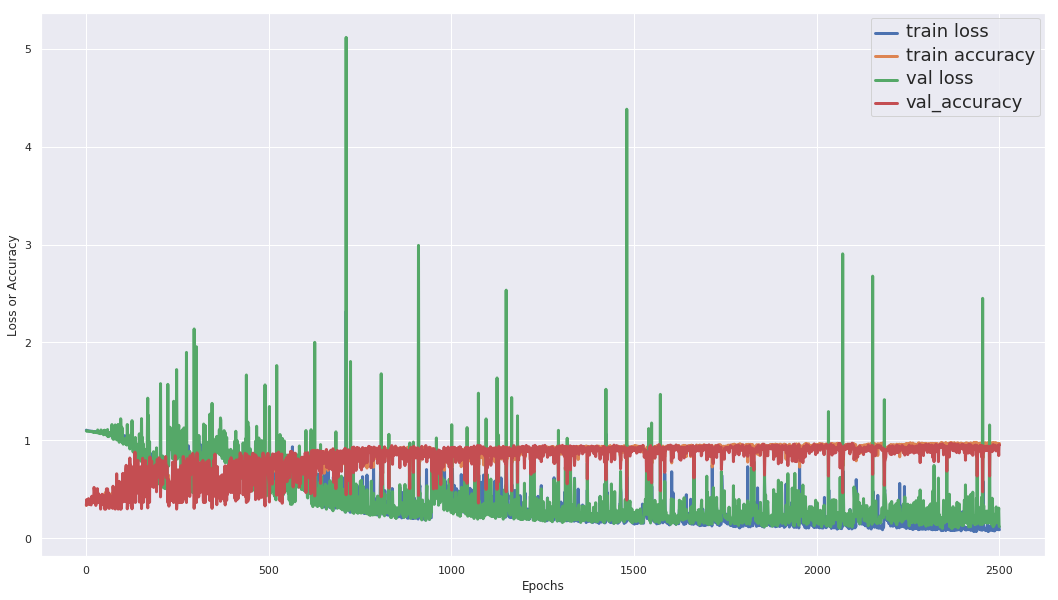

In [16]:
sns.set(font_scale=1)
f, ax = plt.subplots(1, 1, figsize=(18,10))
sns.lineplot(data=plot_df, x='epochs', y='loss', ax=ax, label='train loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='accuracy', ax=ax, label='train accuracy', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='val_loss', ax=ax, label='val loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='val_accuracy', ax=ax, label='val_accuracy', linewidth=3)
ax.set_ylabel('Loss or Accuracy')
ax.set_xlabel('Epochs')
plt.setp(ax.get_legend().get_texts(), fontsize='18'); # for legend text

In [23]:
model.save('./checkpoint')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./checkpoint\assets
